In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.HH.DY import DYDoubleLeptonGenDataset,DYDoubleLeptonRecoDataset
from memflow.read_data import utils
from memflow.callbacks.transfer_flow_callbacks import SamplingCallback

plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

In [3]:
gen_data = RootData(
    files = [
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/DYJetsToLL_M-10to50.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/DYJetsToLL_M-50.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/DYToLL_0J.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/DYToLL_1J.root',
        '/nfs/scratch/fynu/fbury/MEM_data/Transfermer_v3/results/DYToLL_2J.root',
    ],
    treenames = [
        'gen_DY;1',
    ],
    lazy = True,
    N = int(1e6),
)

print (gen_data)

Data object
Loaded branches:
   ... file: 5000000
   ... sample: 5000000
   ... tree: 5000000
Branch in files not loaded:
   ... ISR_10_E
   ... ISR_10_Px
   ... ISR_10_Py
   ... ISR_10_Pz
   ... ISR_10_eta
   ... ISR_10_idx
   ... ISR_10_mass
   ... ISR_10_parent
   ... ISR_10_pdgId
   ... ISR_10_phi
   ... ISR_10_pt
   ... ISR_11_E
   ... ISR_11_Px
   ... ISR_11_Py
   ... ISR_11_Pz
   ... ISR_11_eta
   ... ISR_11_idx
   ... ISR_11_mass
   ... ISR_11_parent
   ... ISR_11_pdgId
   ... ISR_11_phi
   ... ISR_11_pt
   ... ISR_12_E
   ... ISR_12_Px
   ... ISR_12_Py
   ... ISR_12_Pz
   ... ISR_12_eta
   ... ISR_12_idx
   ... ISR_12_mass
   ... ISR_12_parent
   ... ISR_12_pdgId
   ... ISR_12_phi
   ... ISR_12_pt
   ... ISR_13_E
   ... ISR_13_Px
   ... ISR_13_Py
   ... ISR_13_Pz
   ... ISR_13_eta
   ... ISR_13_idx
   ... ISR_13_mass
   ... ISR_13_parent
   ... ISR_13_pdgId
   ... ISR_13_phi
   ... ISR_13_pt
   ... ISR_14_E
   ... ISR_14_Px
   ... ISR_14_Py
   ... ISR_14_Pz
   ... ISR_14_eta
 

In [5]:
gen_dataset = DYDoubleLeptonGenDataset(
    data = gen_data,
    selection = [
        'leptons',
        'bquarks',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    build = True,
    dtype = torch.float32,
)
print (gen_dataset)

Selecting 121103 events out of 121103
leptons is already in data, will not modify it
bquarks is already in data, will not modify it
Saving objects to /auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/dataset/dy_gen
No final state recorded with `final_states_object_name` property, will not compute PS points
Parton dataset with 121103 events
 Initial states pdgids : [21, 21]
 Final states pdgids   : [6, -6, 11, -11]
 Final states masses   : [172.5, 172.5, 0.0005109989499999999, 0.0005109989499999999]
Containing the following tensors
leptons  : data ([121103, 2, 5]), mask ([121103, 2])
           Mask exist    : [100.00%, 100.00%]
           Mask corr     : [True, True]
           Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
           Selected for batches : True
bquarks  : data ([121103, 2, 5]), mask ([121103, 2])
           Mask exist    : [100.00%, 100.00%]
           Mask corr     : [True, True]
           Features      : ['pt', 'eta', 'phi', 'mass', 'pdgId']
           Select

Before preprocessing


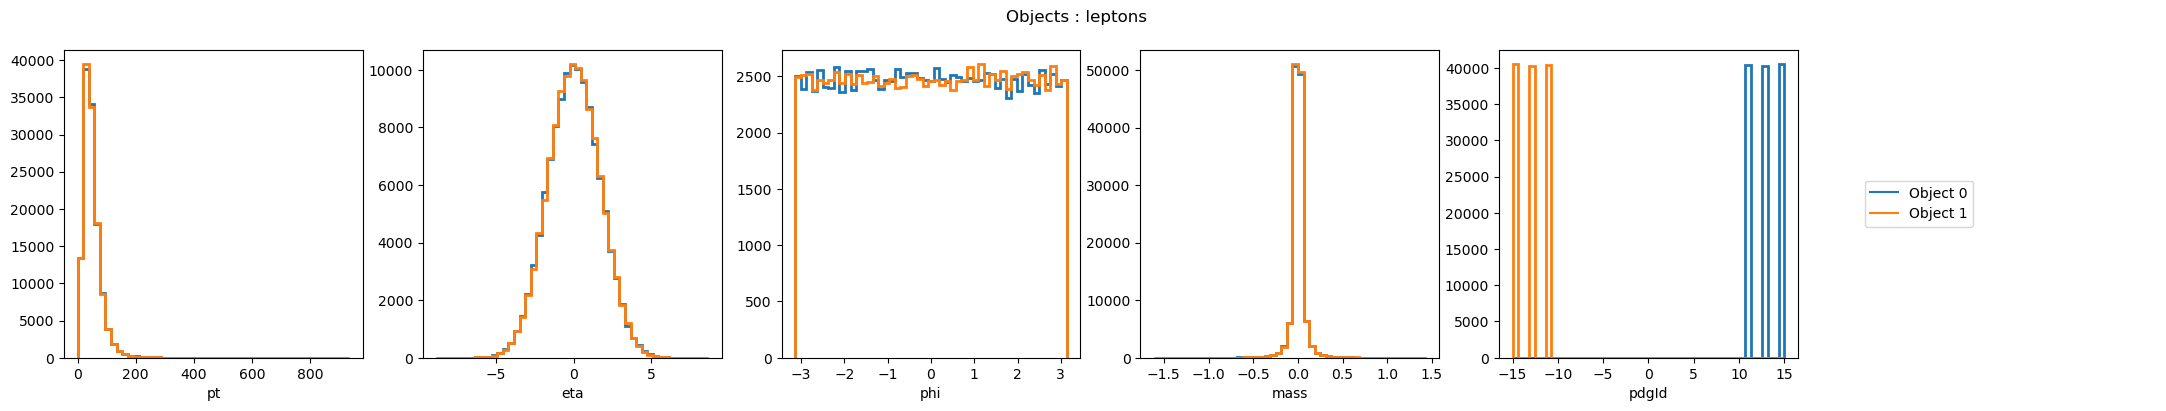

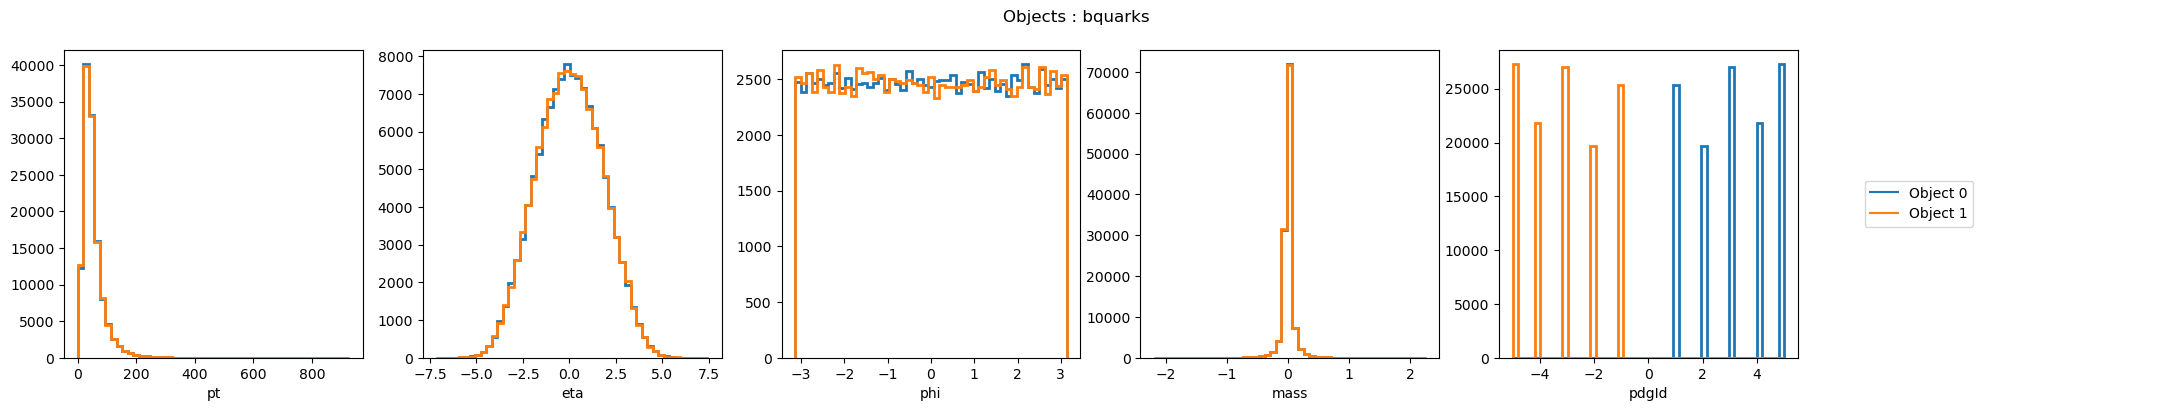

After preprocessing


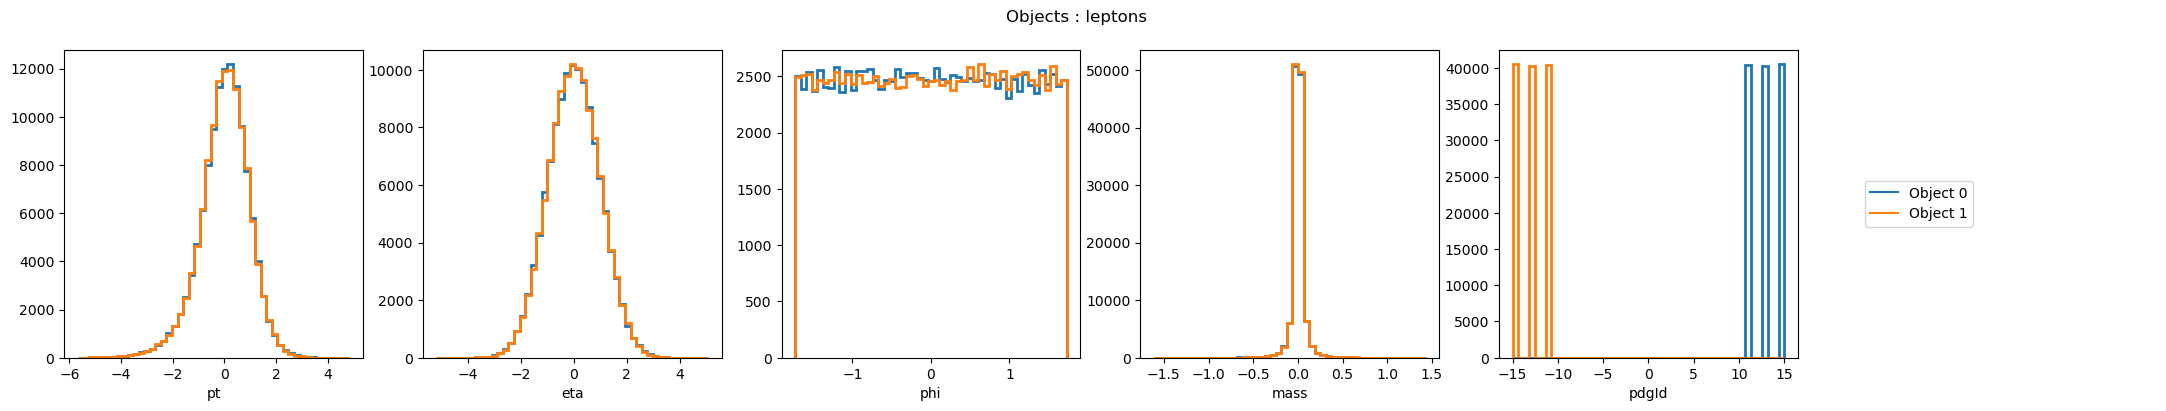

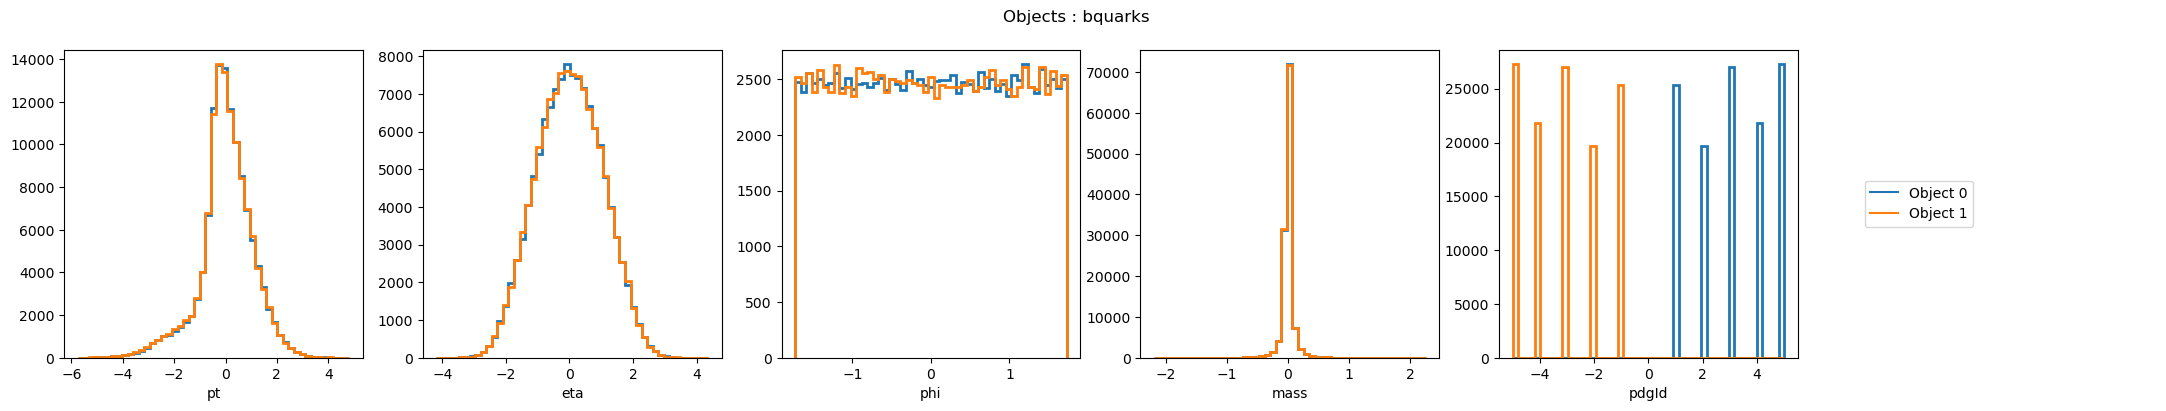

In [6]:
print ('Before preprocessing')
gen_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
gen_dataset.plot(selection=True,raw=False)

In [7]:
loader_gen = DataLoader(
    gen_dataset,
    batch_size = 32,
)
batch = next(iter(loader_gen))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

leptons torch.Size([32, 2, 5]) torch.Size([32, 2])
bquarks torch.Size([32, 2, 5]) torch.Size([32, 2])


In [8]:
reco_data = RootData(
    files = gen_data.files,
    treenames = [
        'reco_DL;1',
    ],
    lazy = True,
    N = gen_data.N,
)
print ('Initial :',reco_data.events)

mask_resolved = np.logical_and.reduce(
    (
        reco_data['flag_SR']==1, 
        reco_data['flag_resolved']==1,
        reco_data['n_AK4']<= 8,
    )
)
reco_data.cut(mask_resolved)
print ('Resolved SR :',reco_data.events)
print (reco_data)


Initial : 5000000
Resolved SR : 26013
Data object
Loaded branches:
   ... file: 26013
   ... flag_SR: 26013
   ... flag_resolved: 26013
   ... n_AK4: 26013
   ... sample: 26013
   ... tree: 26013
Branch in files not loaded:
   ... VBF1_E
   ... VBF1_Px
   ... VBF1_Py
   ... VBF1_Pz
   ... VBF1_eta
   ... VBF1_idx
   ... VBF1_mass
   ... VBF1_phi
   ... VBF1_pt
   ... VBF1_sel
   ... VBF2_E
   ... VBF2_Px
   ... VBF2_Py
   ... VBF2_Pz
   ... VBF2_eta
   ... VBF2_idx
   ... VBF2_mass
   ... VBF2_phi
   ... VBF2_pt
   ... VBF2_sel
   ... VBF3_E
   ... VBF3_Px
   ... VBF3_Py
   ... VBF3_Pz
   ... VBF3_eta
   ... VBF3_idx
   ... VBF3_mass
   ... VBF3_phi
   ... VBF3_pt
   ... VBF3_sel
   ... VBF4_E
   ... VBF4_Px
   ... VBF4_Py
   ... VBF4_Pz
   ... VBF4_eta
   ... VBF4_idx
   ... VBF4_mass
   ... VBF4_phi
   ... VBF4_pt
   ... VBF4_sel
   ... VBF5_E
   ... VBF5_Px
   ... VBF5_Py
   ... VBF5_Pz
   ... VBF5_eta
   ... VBF5_idx
   ... VBF5_mass
   ... VBF5_phi
   ... VBF5_pt
   ... VBF5_sel
 

In [ ]:
reco_dataset = DYDoubleLeptonRecoDataset(
    data = reco_data,
    selection = [
        'muons',
        'electrons',
        'met',
        'jets',
    ],
    coordinates = 'cylindrical',
    apply_boost = False,
    apply_preprocessing = True,
    default_features = {
        'pt': 0.,
        'eta': 0.,
        'phi': 0.,
        'btag' : -1.,
        'btagged': None,
        'pdgId' : 0.,
        'charge' : 0.
    },
    build = True,
    dtype = torch.float32,
)
print (reco_dataset)

In [ ]:
event = 5
print ('jets')
print (reco_dataset._objects['jets'][0][event])
print (reco_dataset._objects['jets'][1][event])
print ('electrons')
print (reco_dataset._objects['electrons'][0][event])
print (reco_dataset._objects['electrons'][1][event])
print ('muons')
print (reco_dataset._objects['muons'][0][event])
print (reco_dataset._objects['muons'][1][event])
print ('met')
print (reco_dataset._objects['met'][0][event])
print (reco_dataset._objects['met'][1][event])

In [ ]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

In [ ]:
loader_reco = DataLoader(
    reco_dataset,
    batch_size = 32,
)
batch = next(iter(loader_reco))

for obj,mask,sel in zip(batch['data'],batch['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
comb_dataset = CombinedDataset(
    gen_dataset = gen_dataset,
    reco_dataset = reco_dataset,
    intersection_branch = 'event',
)
print (comb_dataset)

In [ ]:
loader_comb = DataLoader(
    comb_dataset,
    batch_size = 256,
)
batch = next(iter(loader_comb))

print ('Reco')
for obj,mask,sel in zip(batch['reco']['data'],batch['reco']['mask'],loader_reco.dataset.selection):
    print (sel,obj.shape,mask.shape)
print ('Gen')
for obj,mask,sel in zip(batch['gen']['data'],batch['gen']['mask'],loader_gen.dataset.selection):
    print (sel,obj.shape,mask.shape)

In [ ]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number

train_frac = 0.8
indices = torch.arange(len(comb_dataset))
sep = int(train_frac*len(comb_dataset))
train_indices = indices[:sep]
valid_indices = indices[sep:]

comb_dataset_train = torch.utils.data.Subset(comb_dataset,train_indices)
comb_dataset_valid = torch.utils.data.Subset(comb_dataset,valid_indices)
print (len(comb_dataset_train),len(comb_dataset_valid))

batch_size = 5000

loader_comb_train = DataLoader(
    comb_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_comb_valid = DataLoader(
    comb_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)

In [ ]:
from memflow.transfer_flow.transfer_flow_model import TransferFlow

model = TransferFlow(
    embed_dim = 64,
    embed_act = nn.GELU,
    n_gen_particles_per_type = gen_dataset.number_particles_per_type,
    gen_particle_type_names = gen_dataset.selection,
    gen_input_features_per_type = gen_dataset.input_features,
    n_reco_particles_per_type = reco_dataset.number_particles_per_type,
    reco_particle_type_names = reco_dataset.selection,
    reco_input_features_per_type = reco_dataset.input_features,
    flow_input_features = [
        ['pt','eta','phi'], # electrons
        ['pt','eta','phi'], # muons
        ['pt','phi'],       # met
        ['pt','eta','phi'], # jets
    ],
    reco_mask_corr = reco_dataset.correlation_mask,
    gen_mask_corr = gen_dataset.correlation_mask,
    transformer_args = {
        'nhead' : 8,
        'num_encoder_layers' : 6, 
        'num_decoder_layers' : 6, 
        'dim_feedforward' : 256, 
        'dropout' : 0., 
        'activation' : 'gelu', 
    },
    flow_args = {
        'bins' : 16,
        'transforms' : 5,
        'randperm' : True,
        'passes' : 2,
        # 'univariate'
        # 'univariate_kwargs' : {"bound": 1},
        'hidden_features' : [64] * 5,   
    },
    onehot_encoding = True,
)

batch = next(iter(loader_comb))
print (model(batch))

print (model)

In [ ]:
idx_ee = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 2,
    ]
)
idx_mm = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['muons'],axis=1) == 2,
    ]
)
idx_em = comb_dataset.find_indices(
    reco_masks = [
        ak.count(reco_data['jets'],axis=1) == 8,
        ak.count(reco_data['electrons'],axis=1) == 1,
        ak.count(reco_data['muons'],axis=1) == 1,
    ]
)
for channel,idx in zip(['ee','mm','em'],[idx_ee,idx_mm,idx_em]):
    print (channel)
    for i in idx[:3]:
        event = comb_dataset[i]
        print ('\t idx:',i)
        print ('\t reco: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['reco']['data'],event['reco']['mask']):
            print (f'\t\t{name:15s}',data.shape,mask)
        print ('\t gen: ')
        for name,data,mask in zip(comb_dataset.reco_dataset.selection,event['gen']['data'],event['gen']['mask']):
            print (f'\t\t{name:15s}')
            print (f'\t\t',data)
            print (f'\t\t',mask)


In [18]:
idx_to_monitor = [3664,1280,301]
print ('Reco')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['reco']['data'],comb_dataset[idx]['reco']['mask'],comb_dataset.reco_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)
print ('Gen')
for idx in idx_to_monitor:
    print ('idx',idx)
    for data,mask,name in zip(comb_dataset[idx]['gen']['data'],comb_dataset[idx]['gen']['mask'],comb_dataset.gen_dataset.selection):
        print ('\t',name)
        print ('\t',data.shape)
        print ('\t',mask)


Reco
idx 3664
	 electrons
	 torch.Size([2, 7])
	 tensor([1., 1.])
	 muons
	 torch.Size([2, 7])
	 tensor([0., 0.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
idx 1280
	 electrons
	 torch.Size([2, 7])
	 tensor([0., 0.])
	 muons
	 torch.Size([2, 7])
	 tensor([1., 1.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
idx 301
	 electrons
	 torch.Size([2, 7])
	 tensor([1., 0.])
	 muons
	 torch.Size([2, 7])
	 tensor([1., 0.])
	 met
	 torch.Size([1, 7])
	 tensor([1.])
	 jets
	 torch.Size([8, 7])
	 tensor([1., 1., 1., 1., 1., 1., 1., 1.])
Gen
idx 3664
	 leptons
	 torch.Size([4, 4])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2, 4])
	 tensor([1., 1.])
idx 1280
	 leptons
	 torch.Size([4, 4])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2, 4])
	 tensor([1., 1.])
idx 301
	 leptons
	 torch.Size([4, 4])
	 tensor([1., 1., 1., 1.])
	 bquarks
	 torch.Size([2,

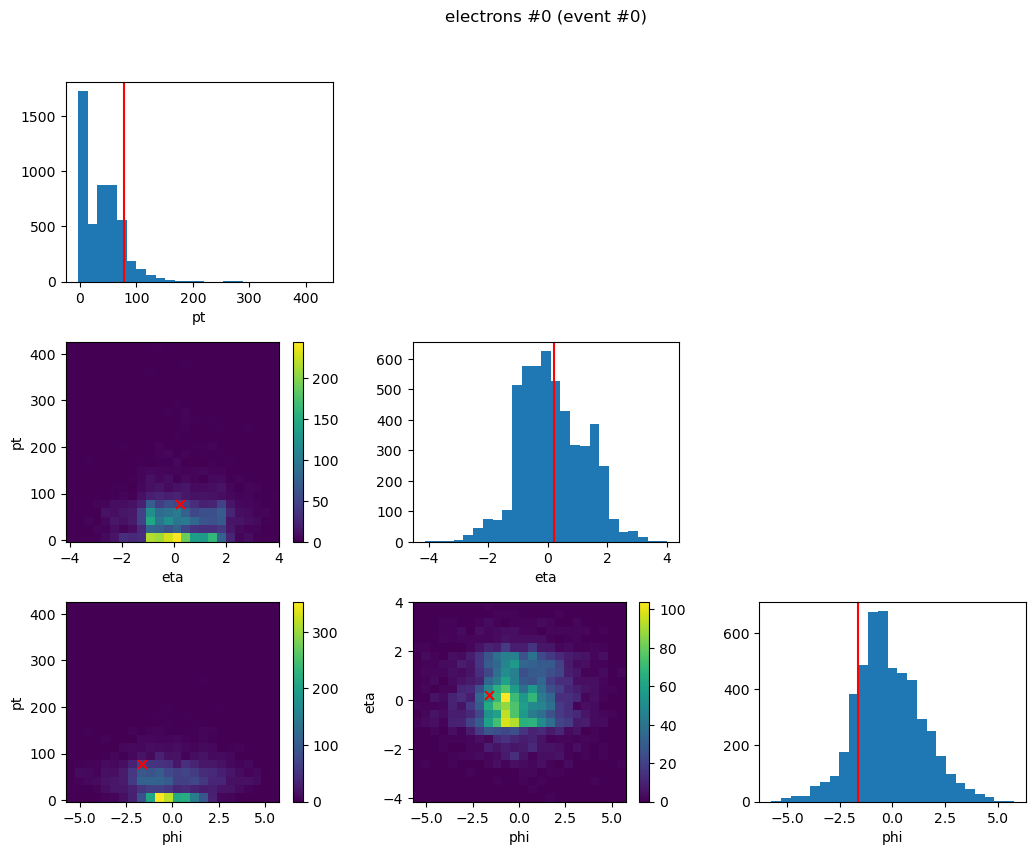

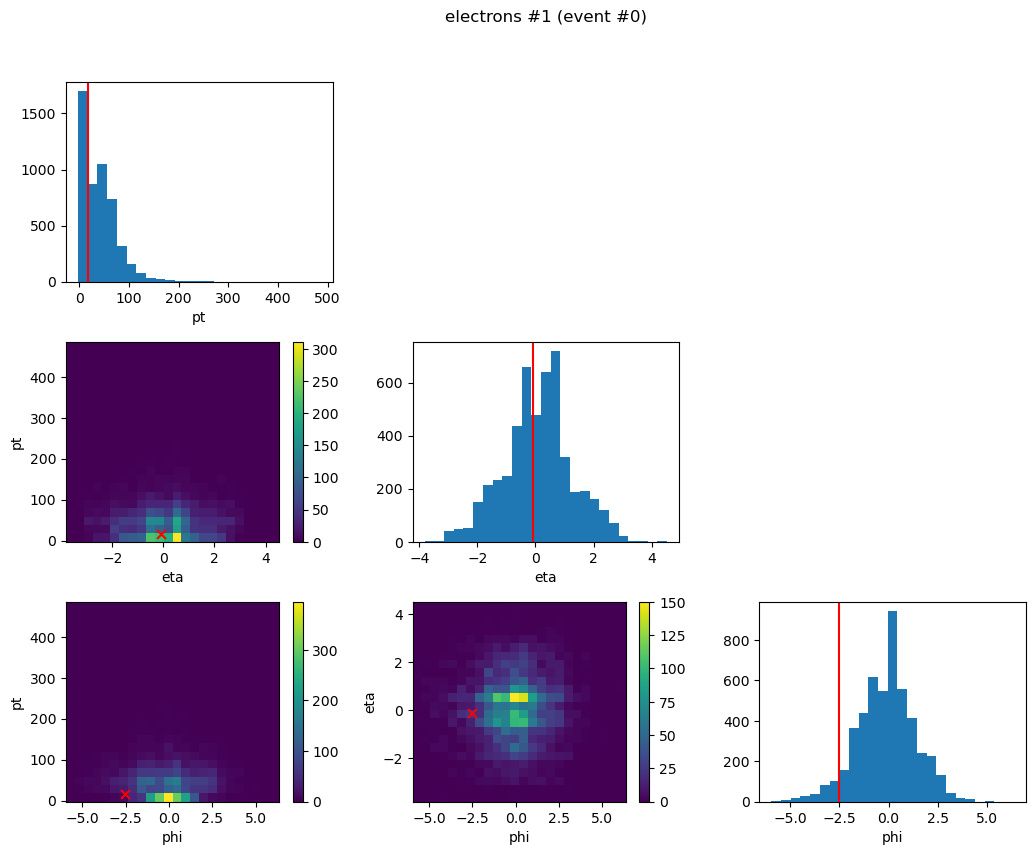

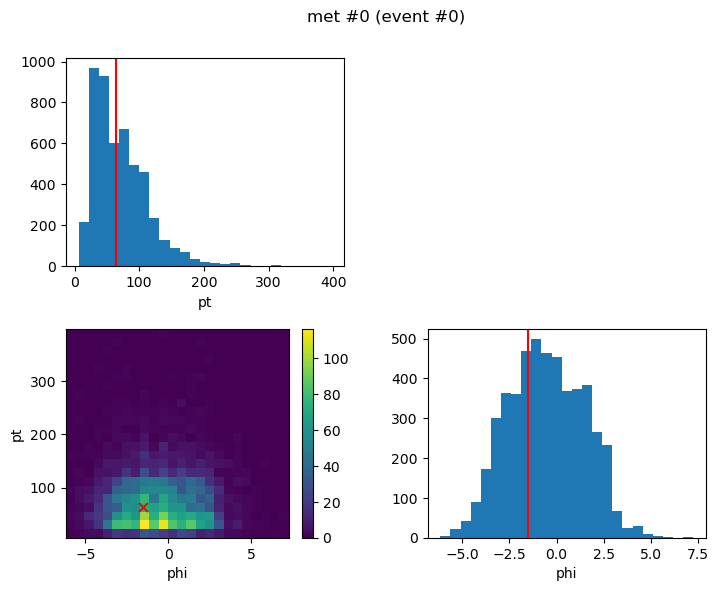

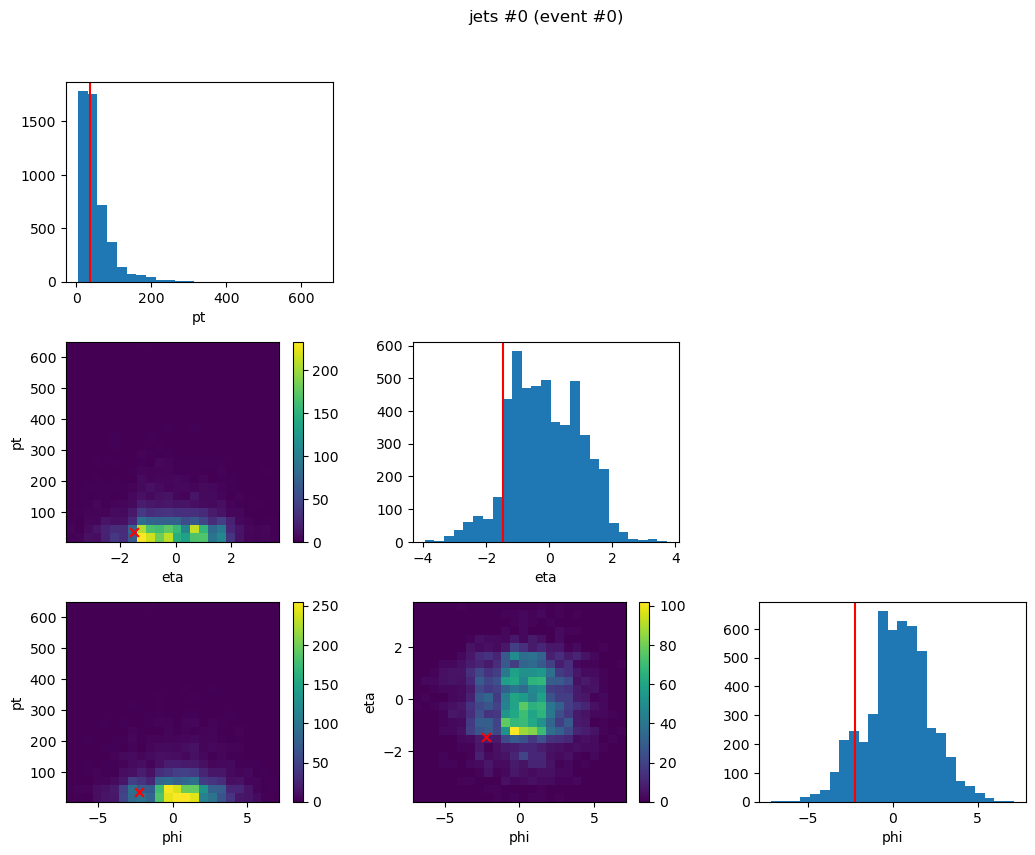

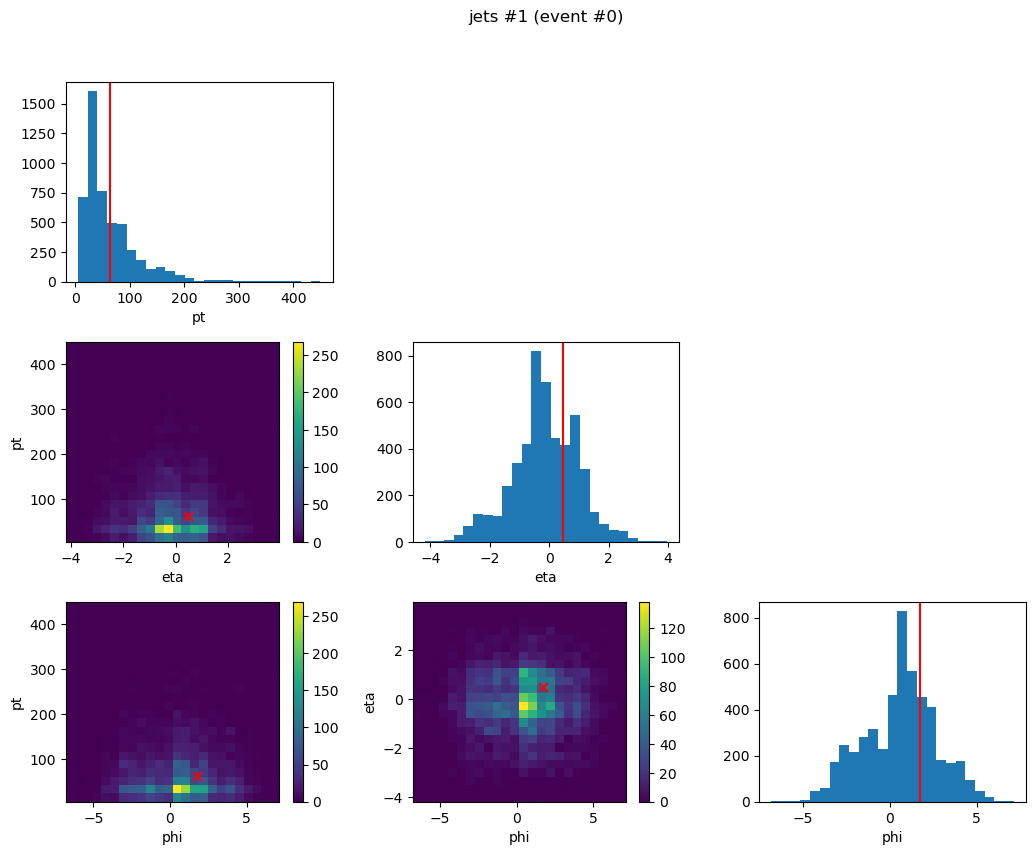

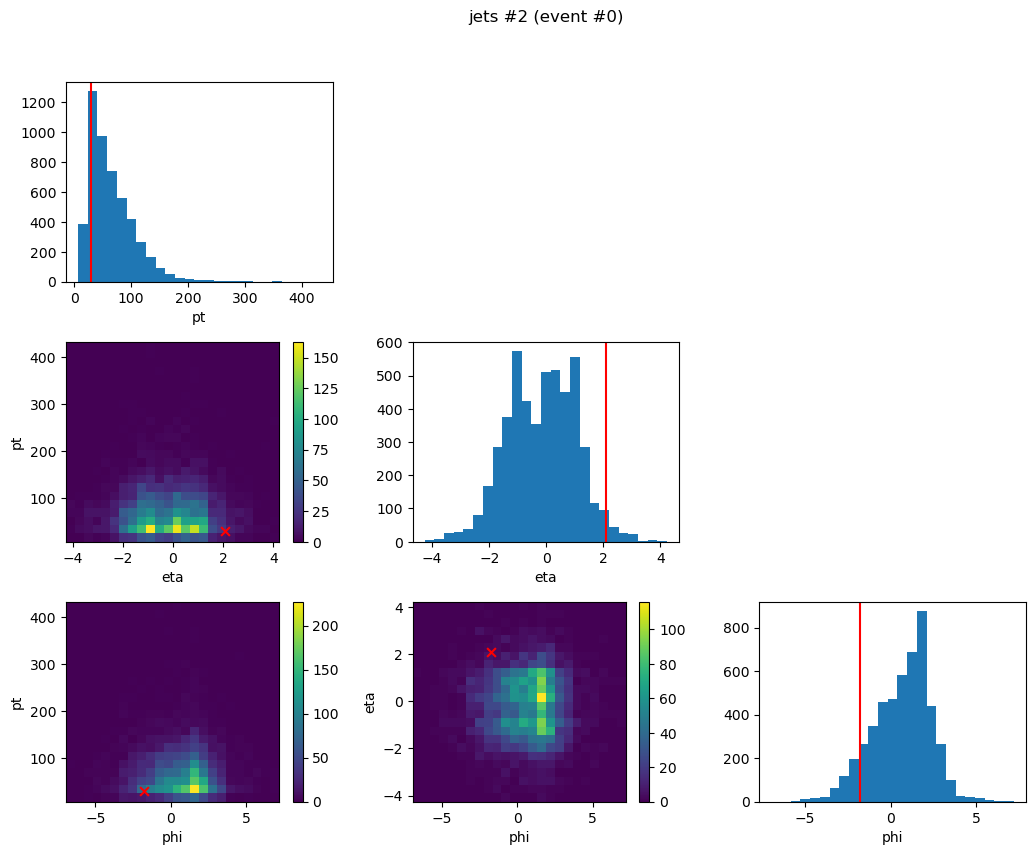

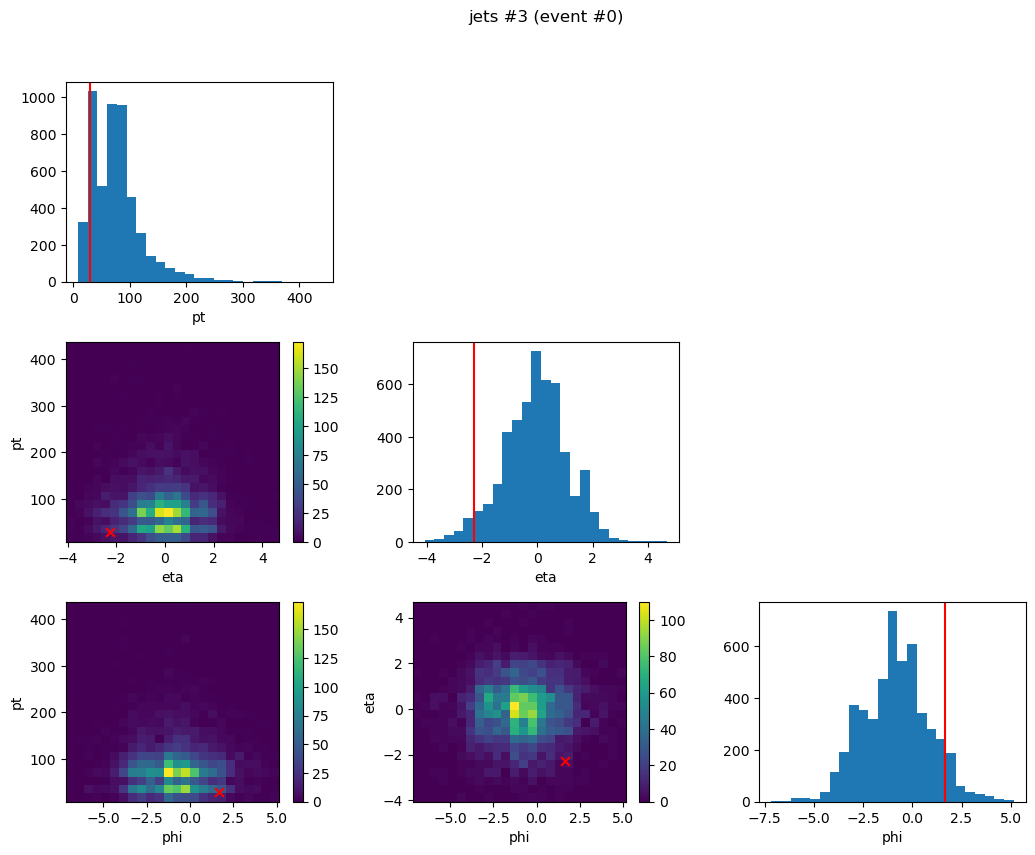

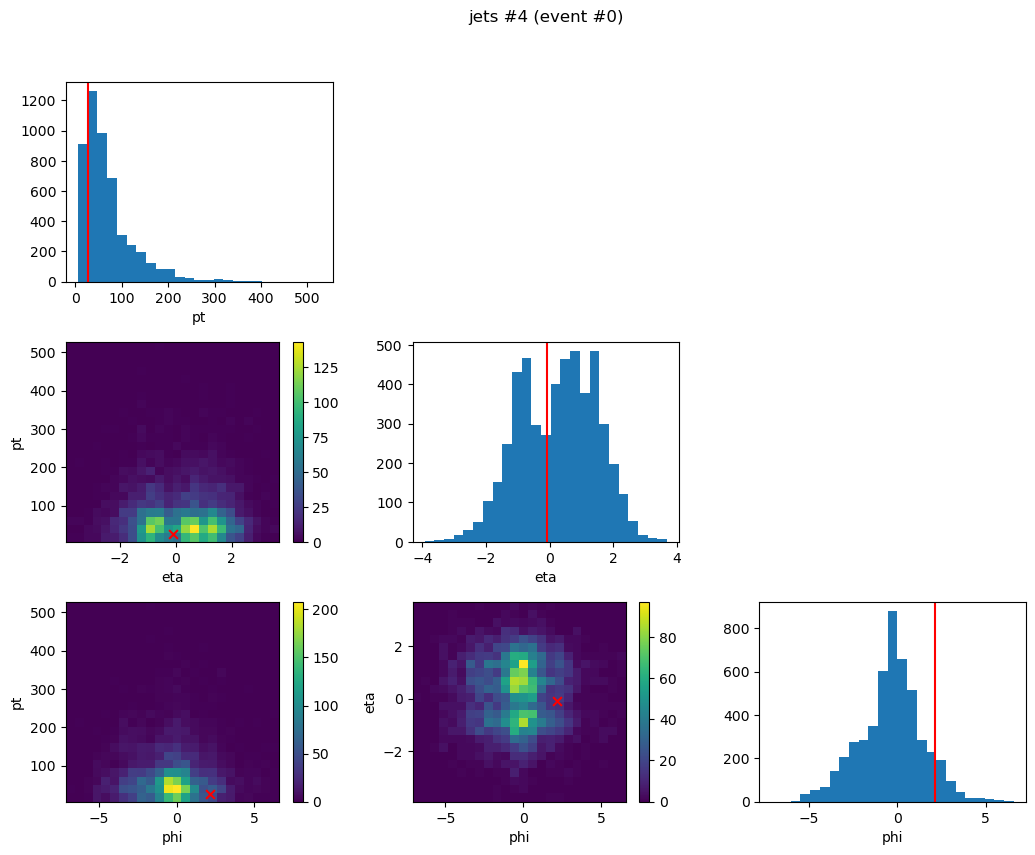

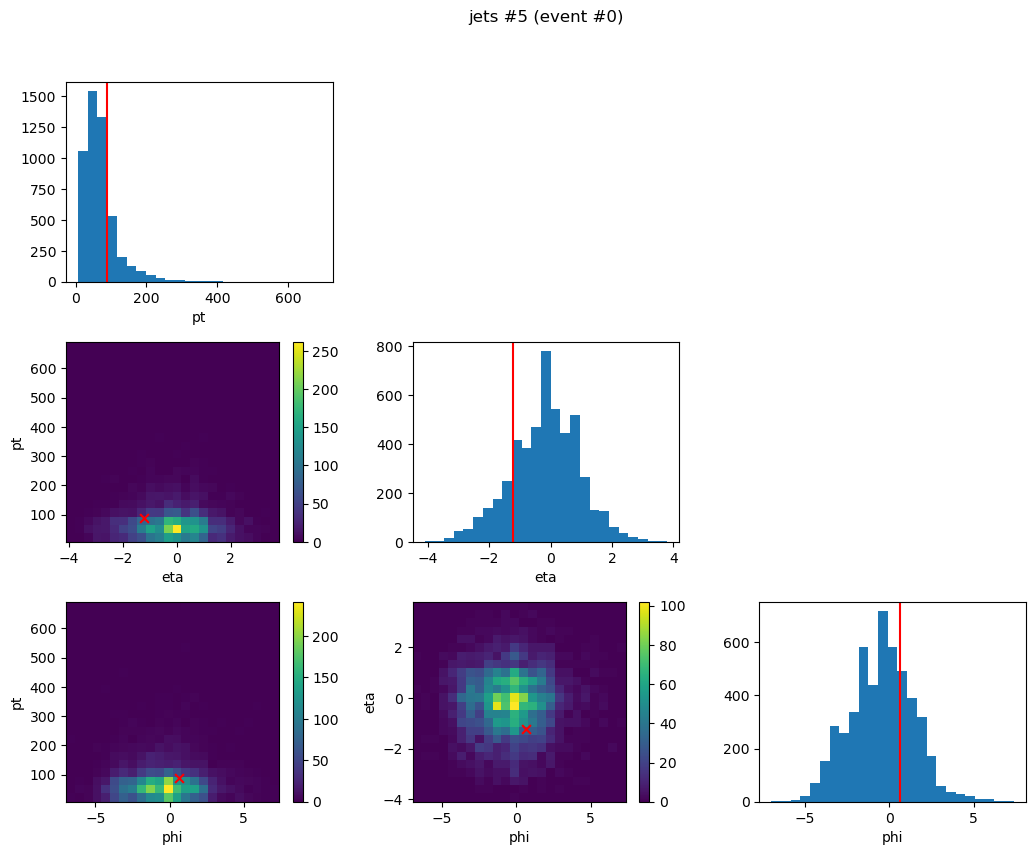

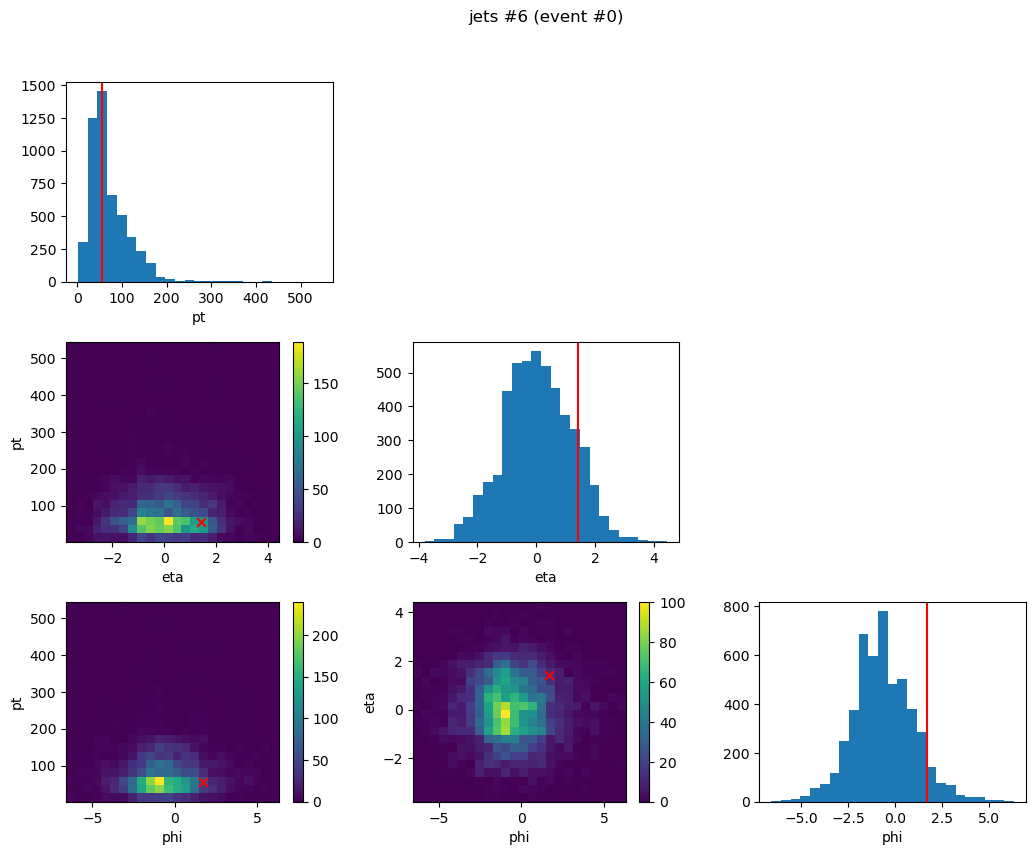

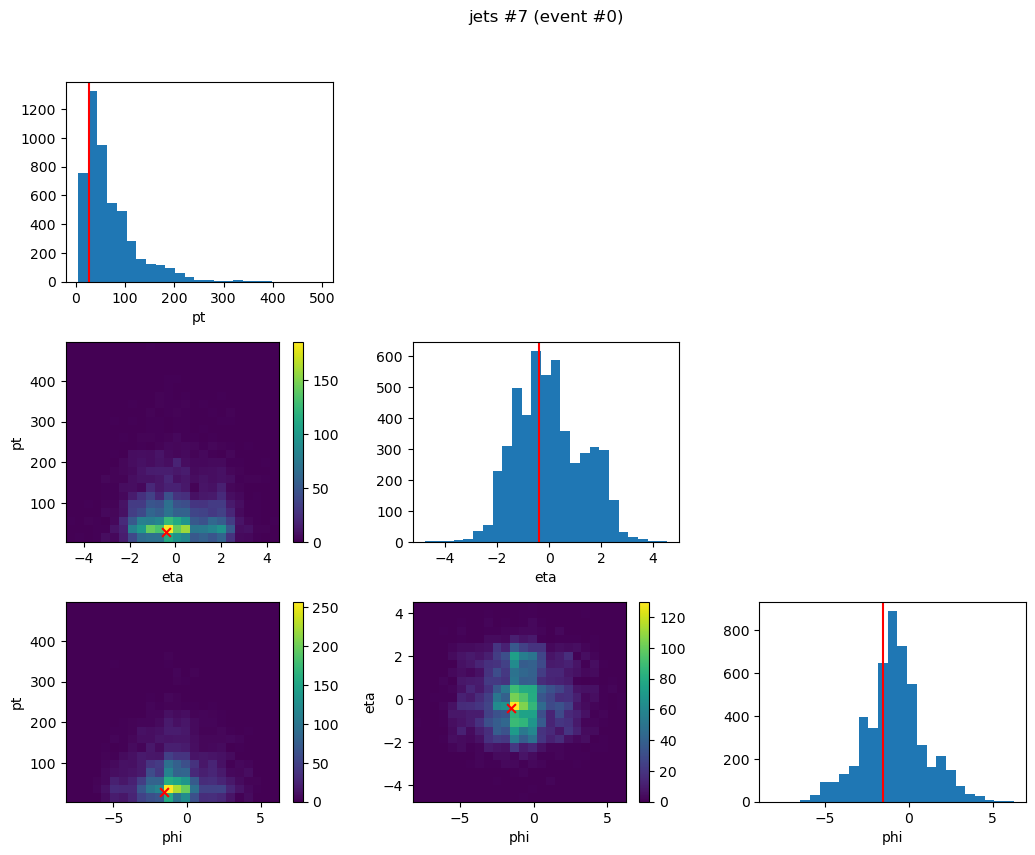

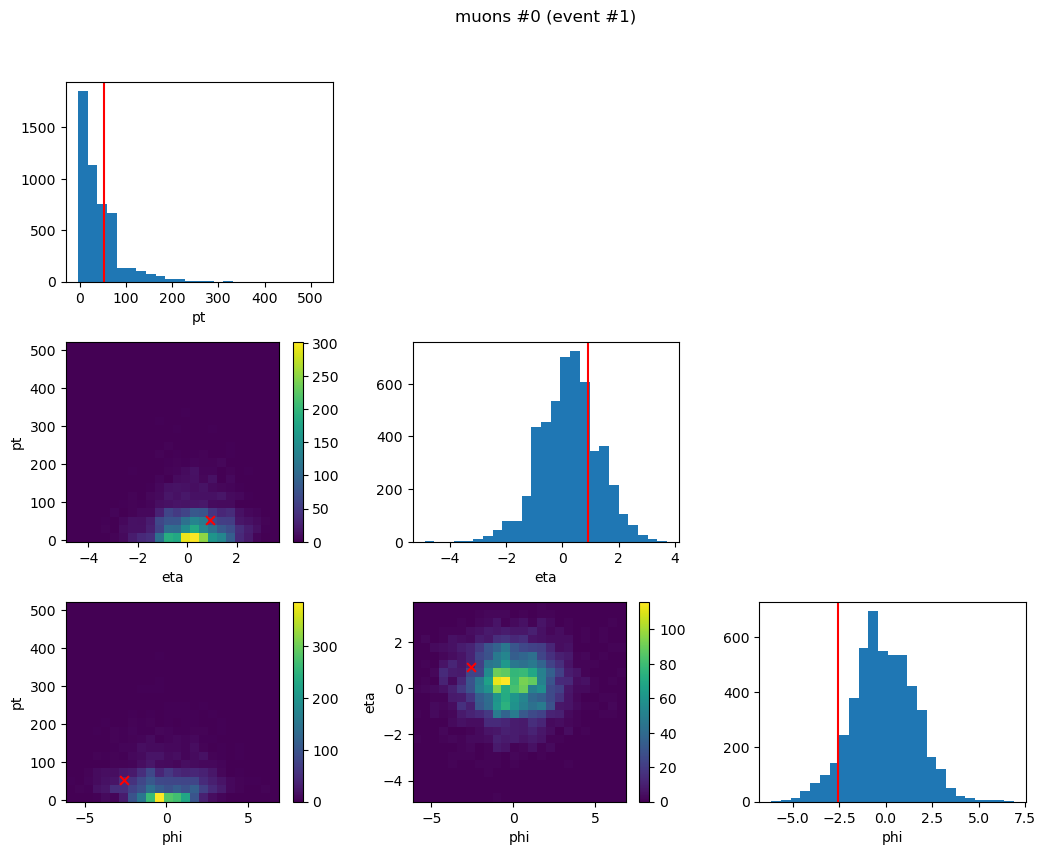

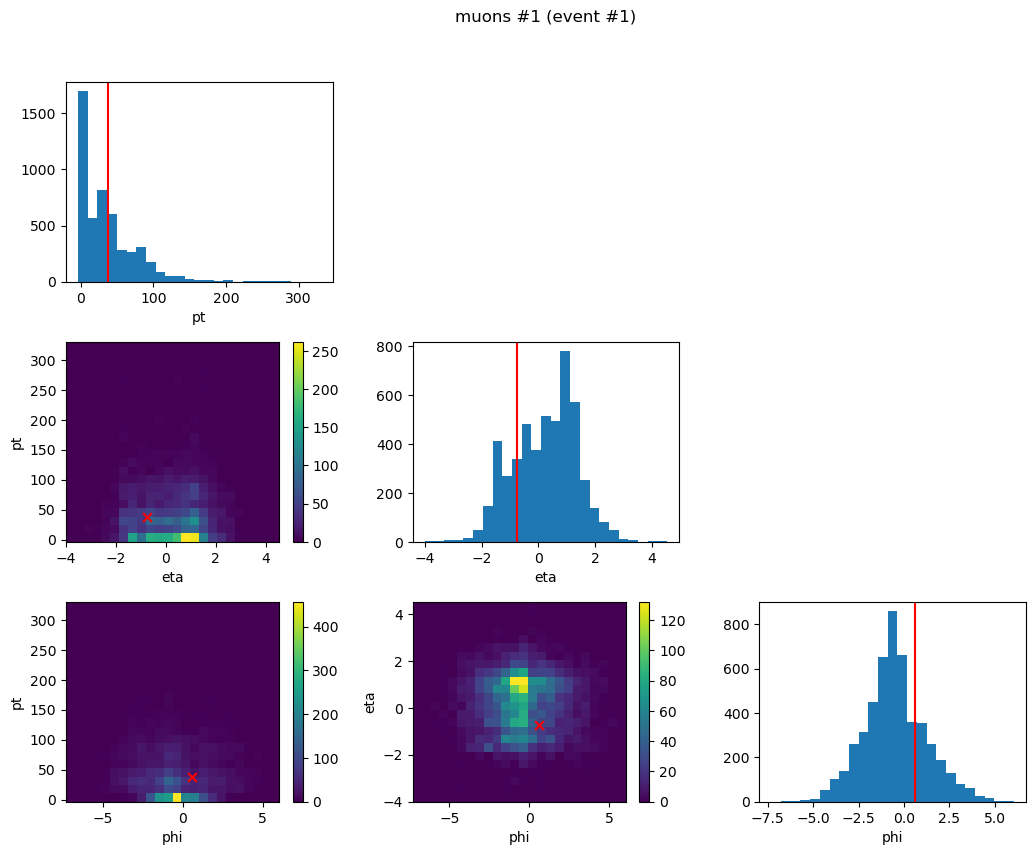

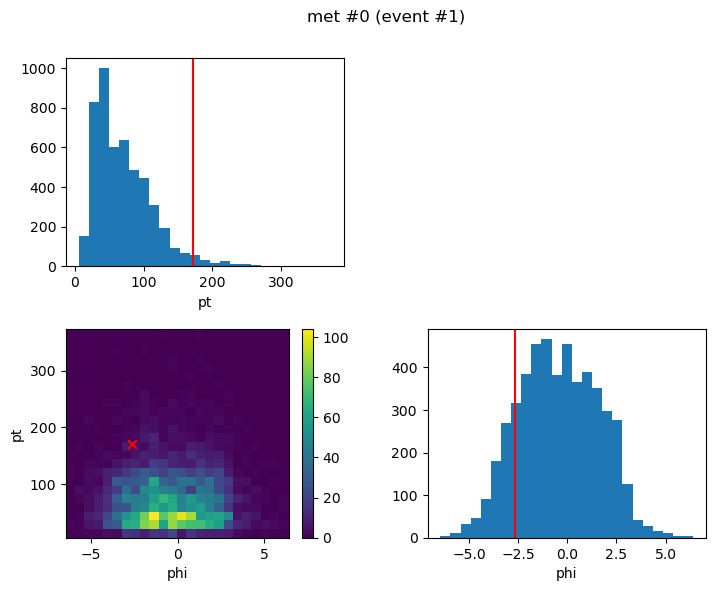

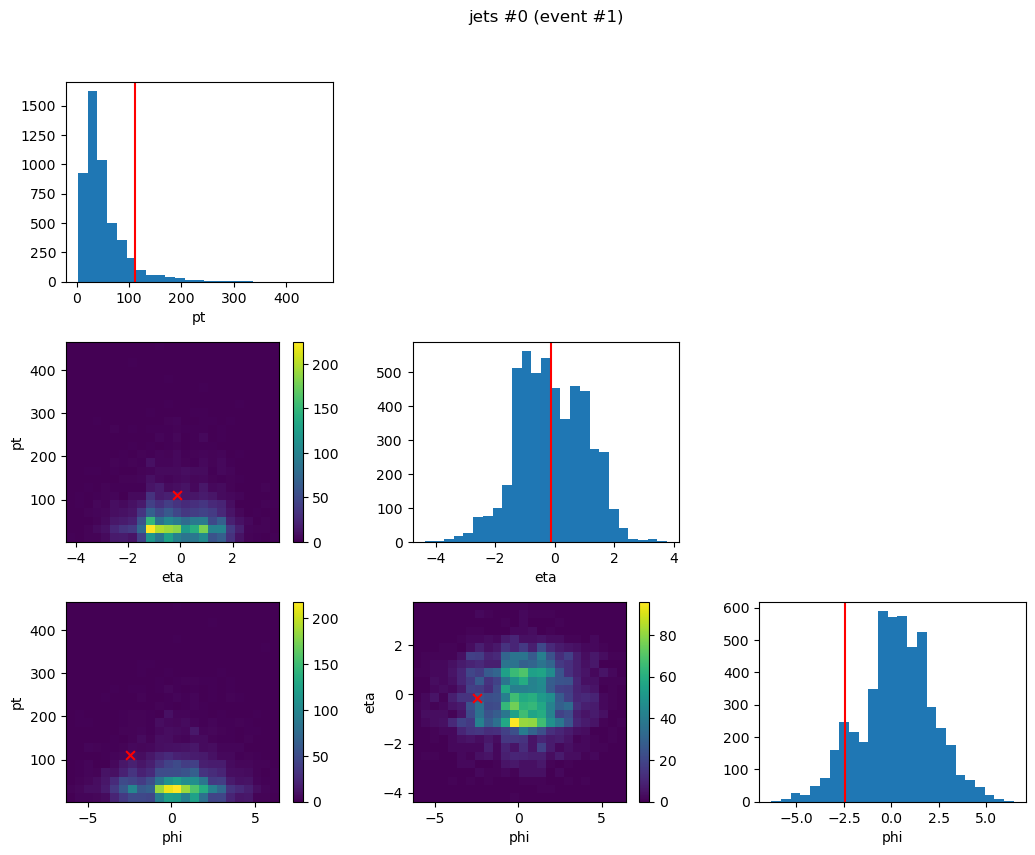

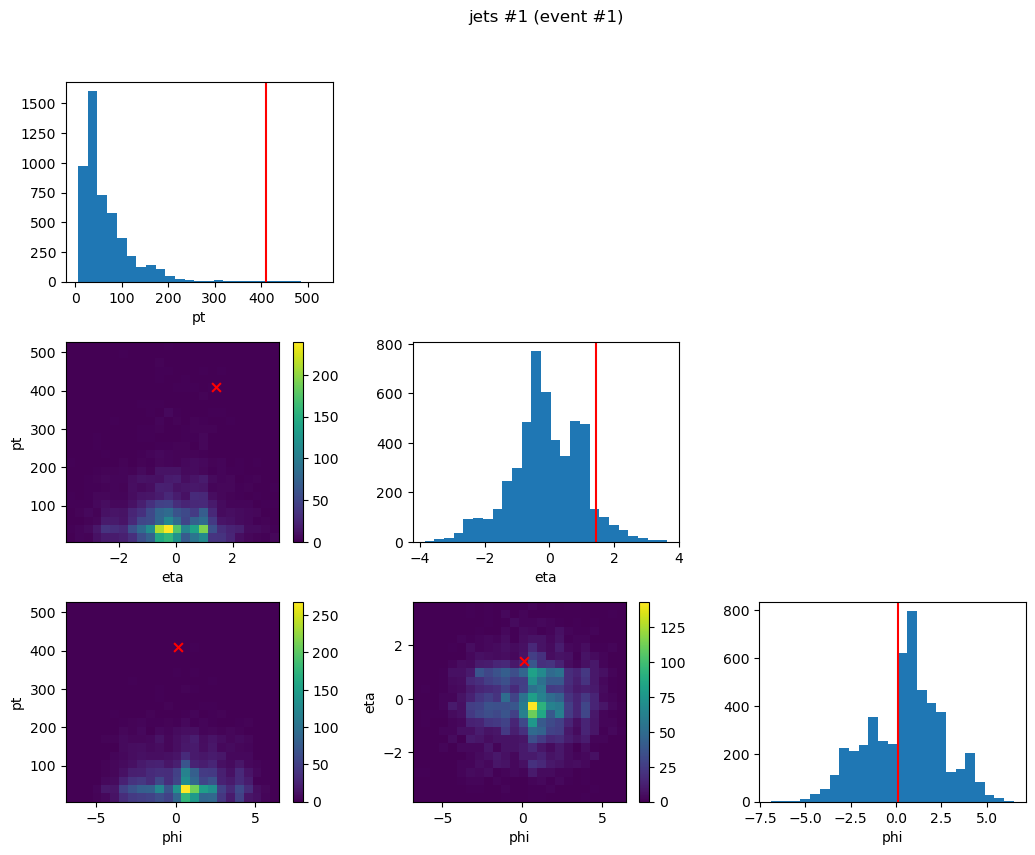

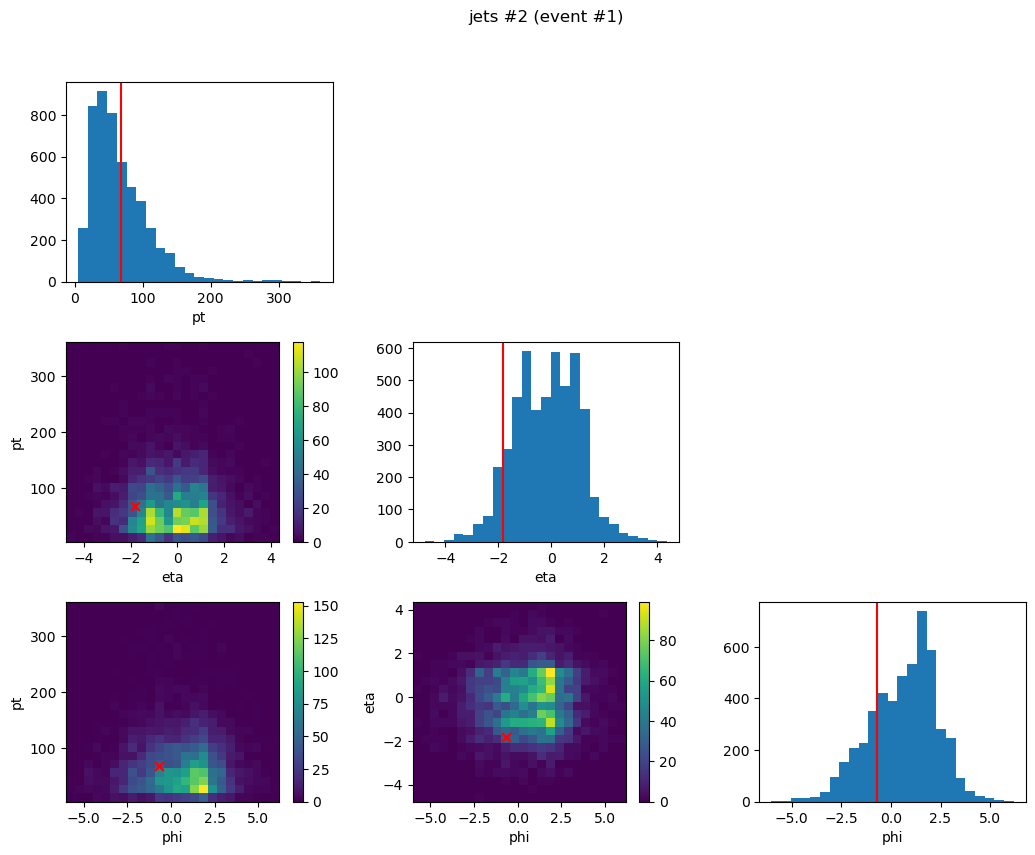

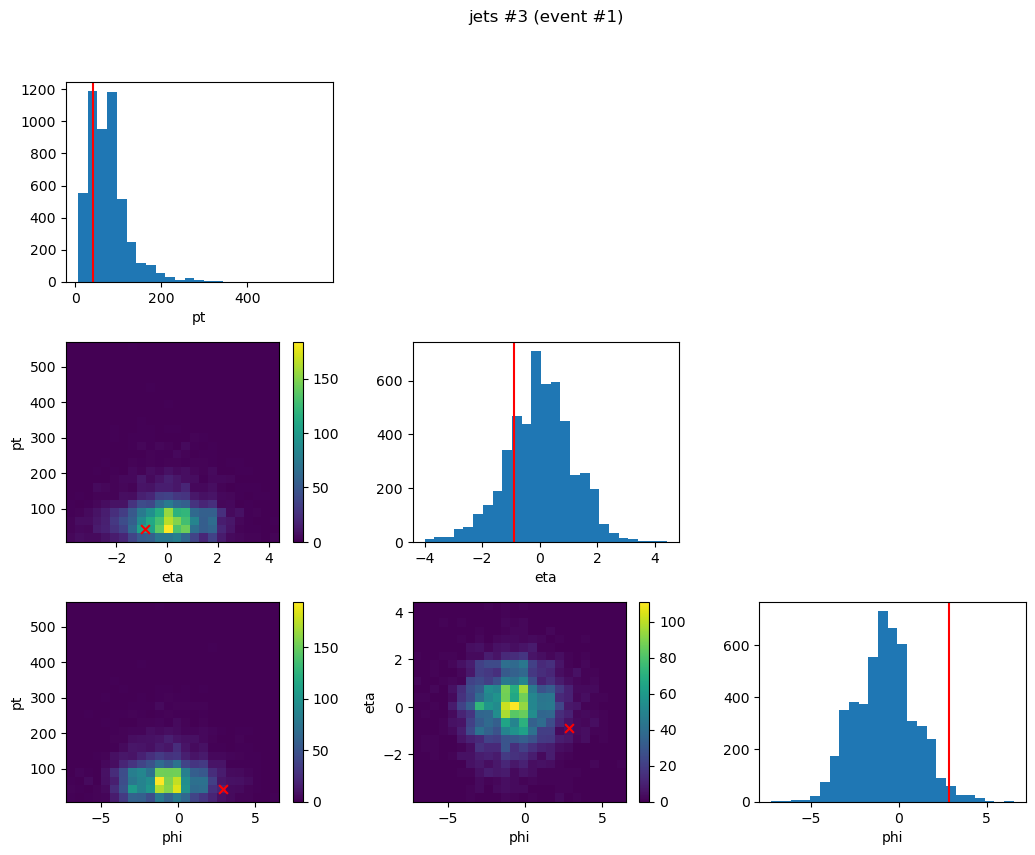

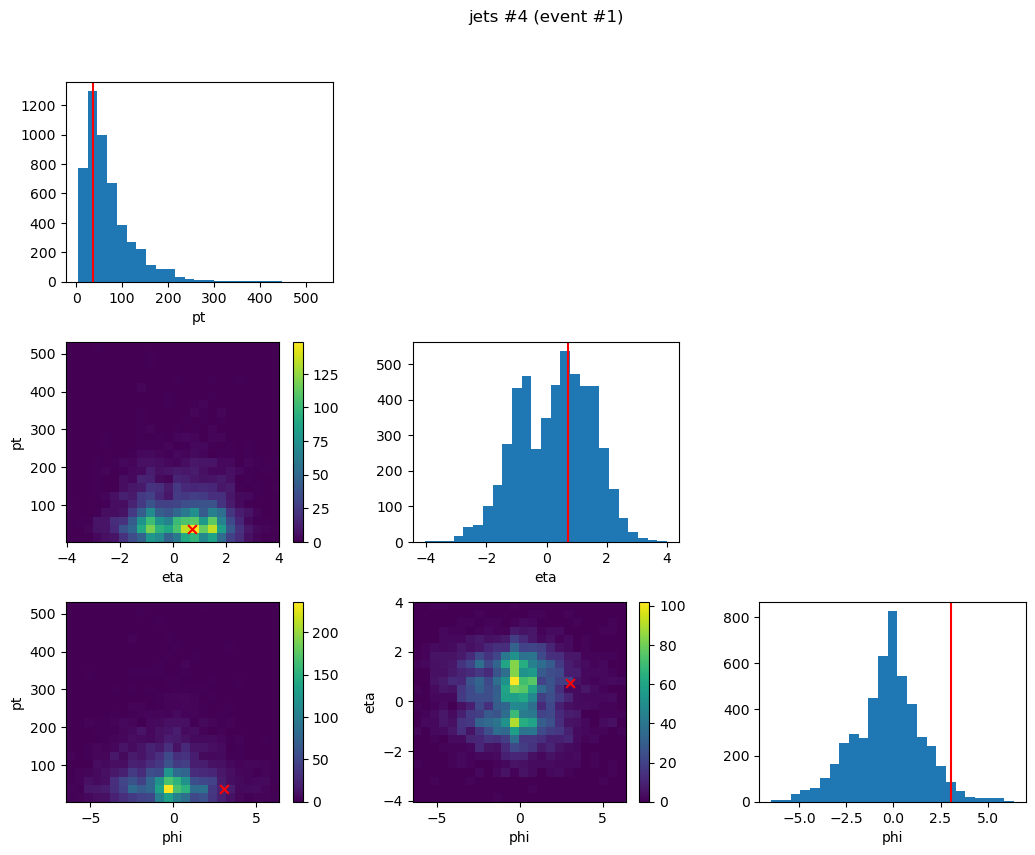

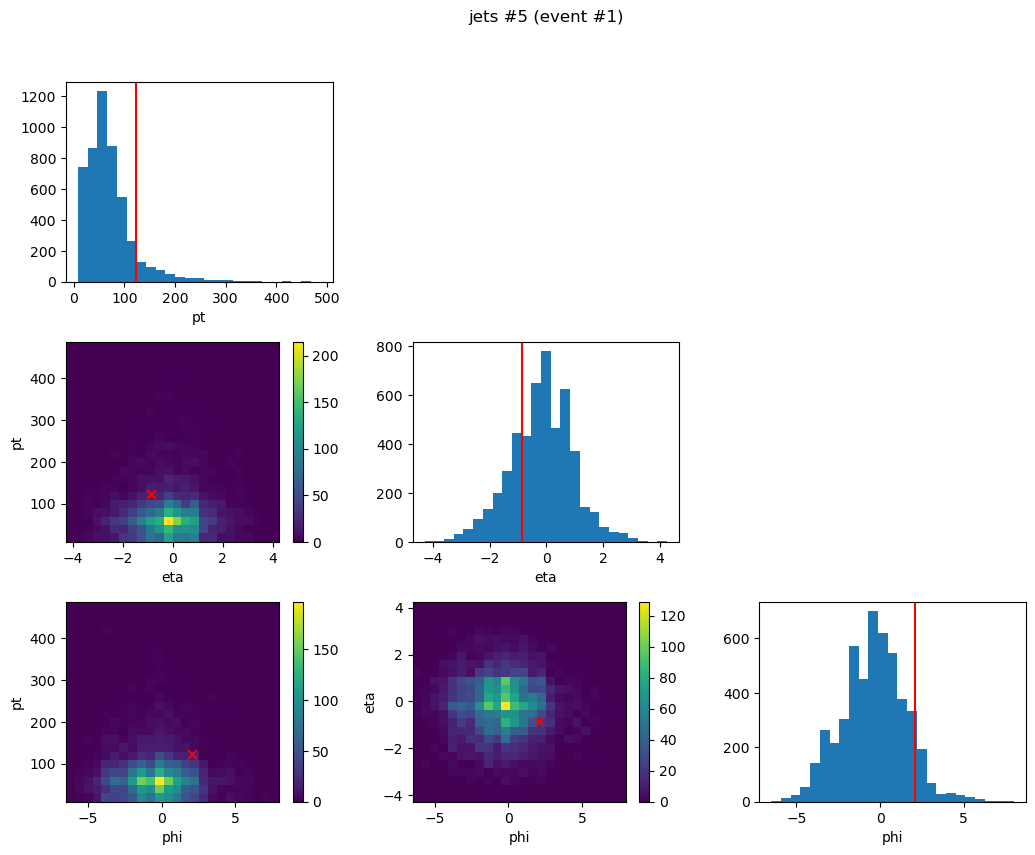

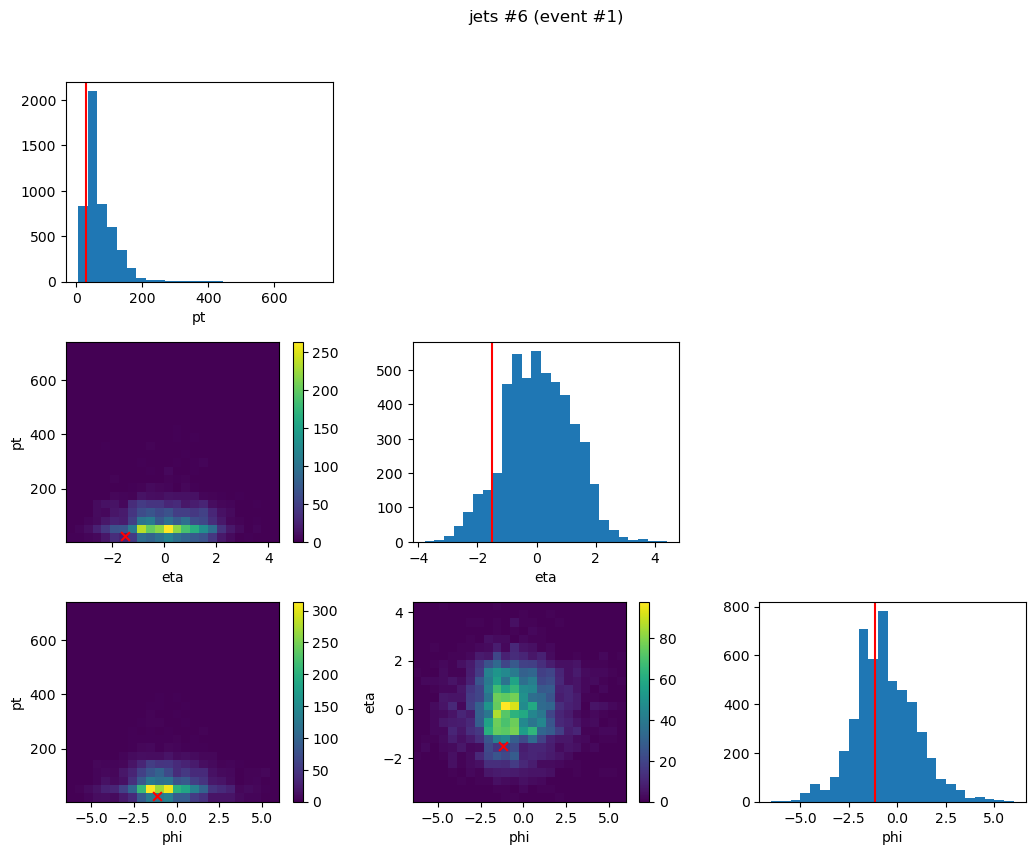

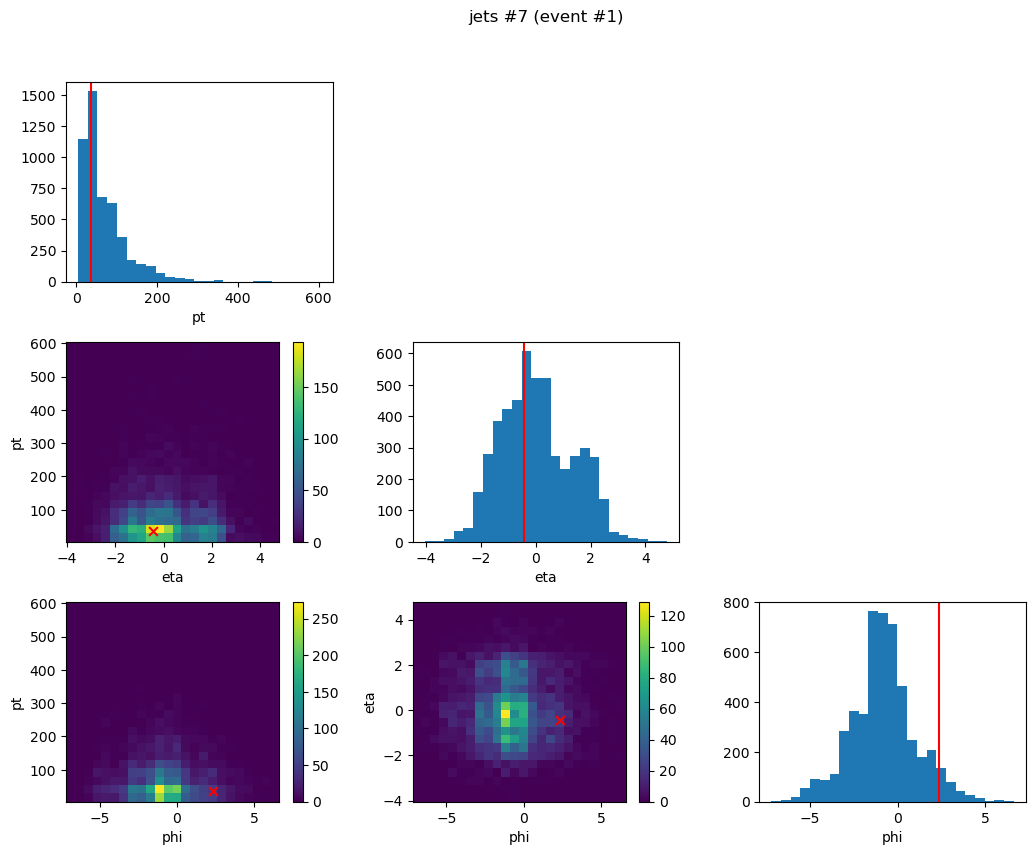

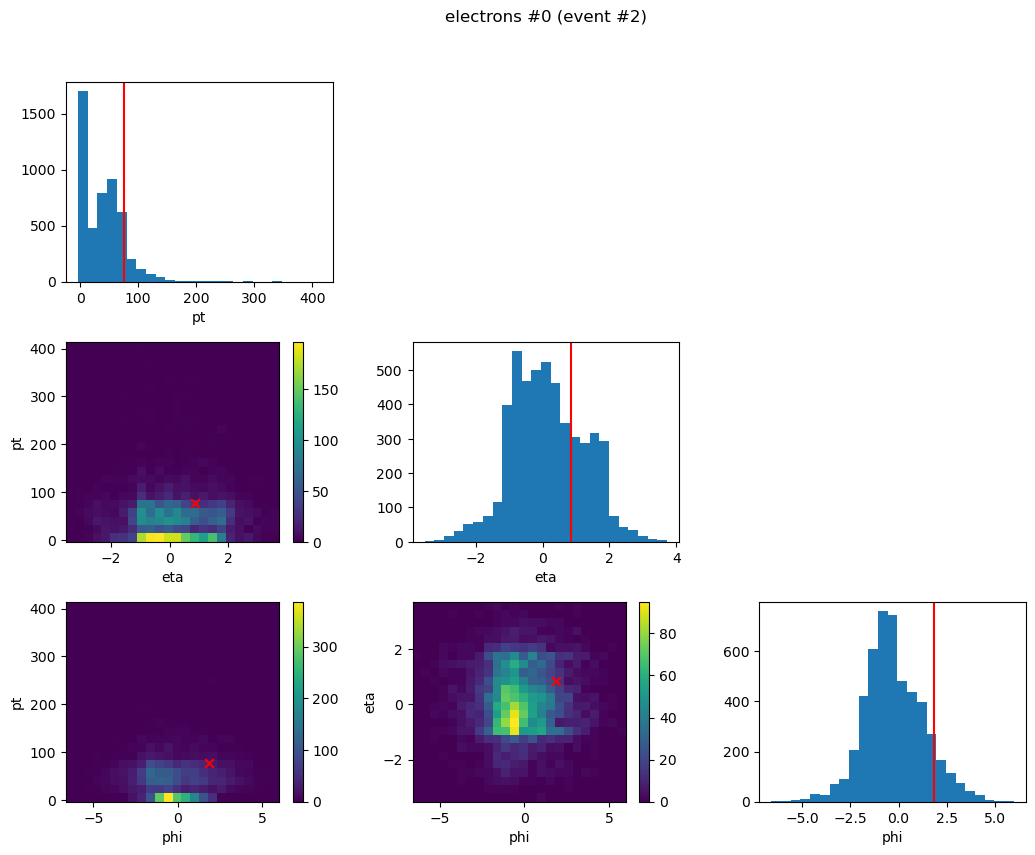

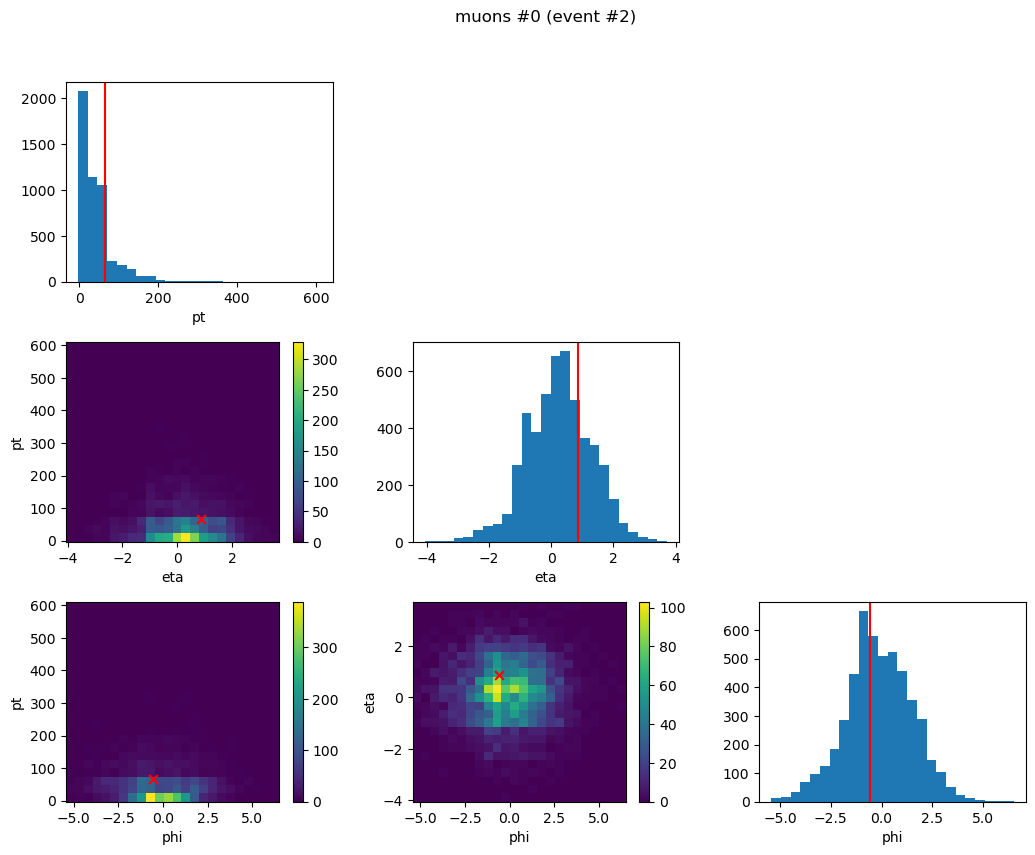

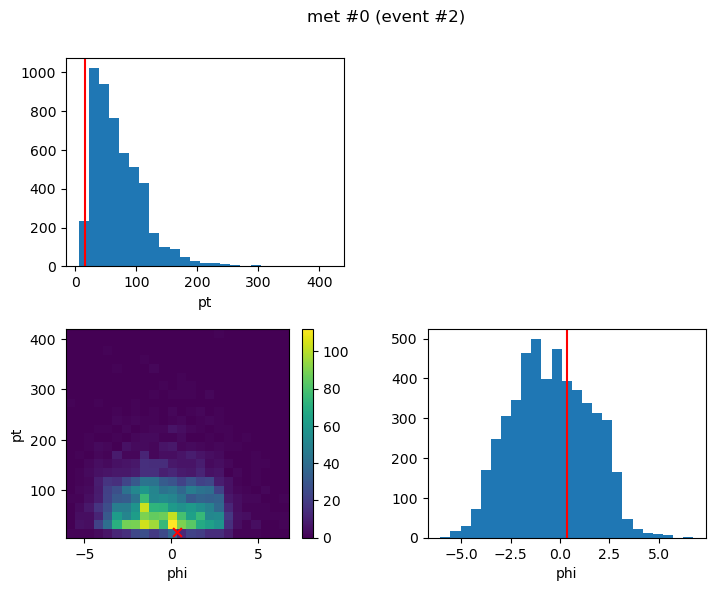

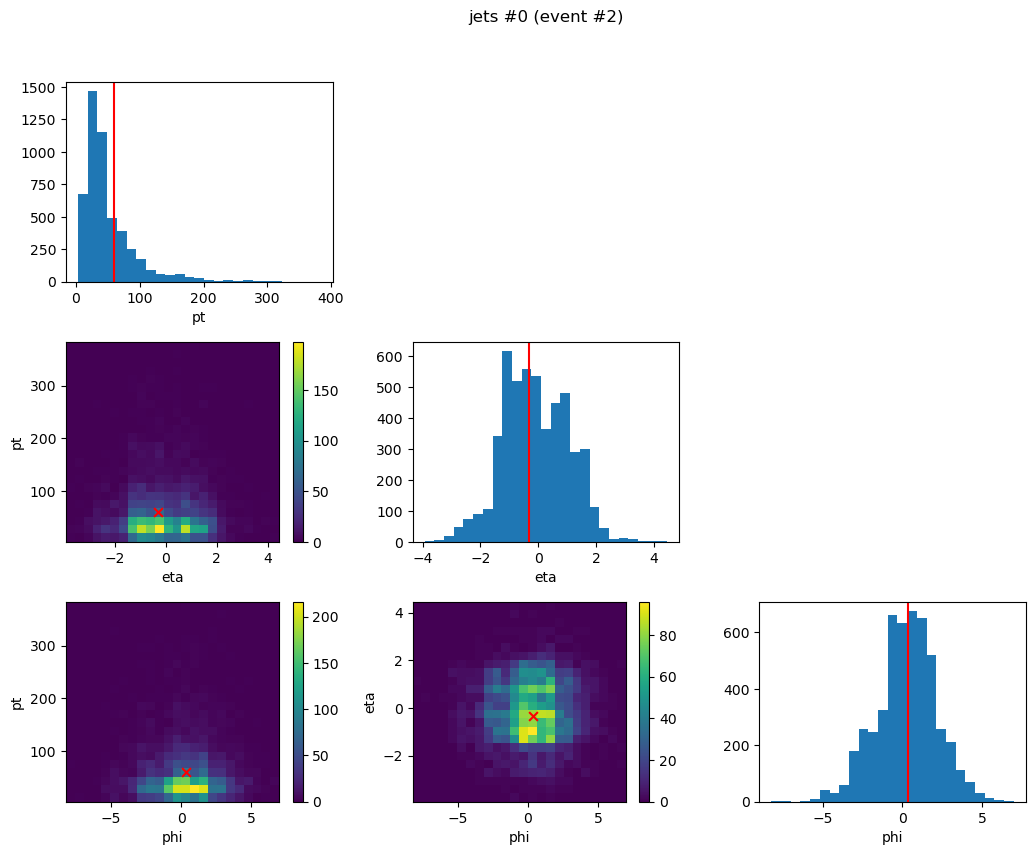

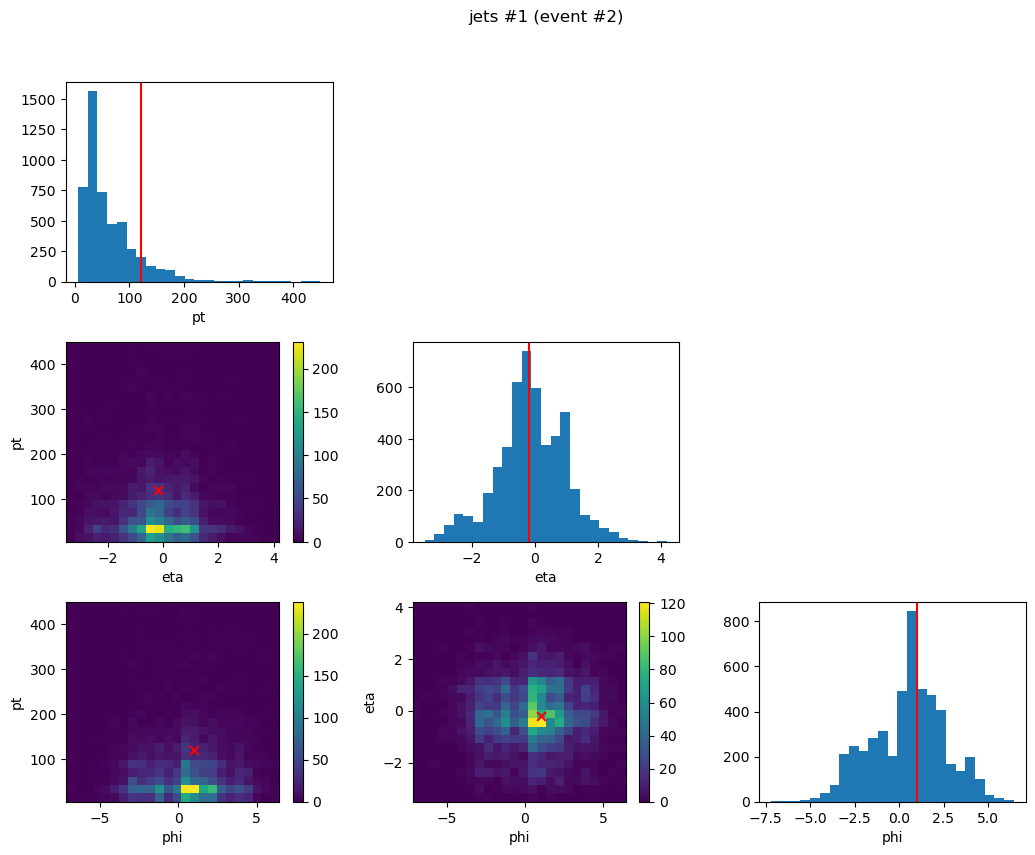

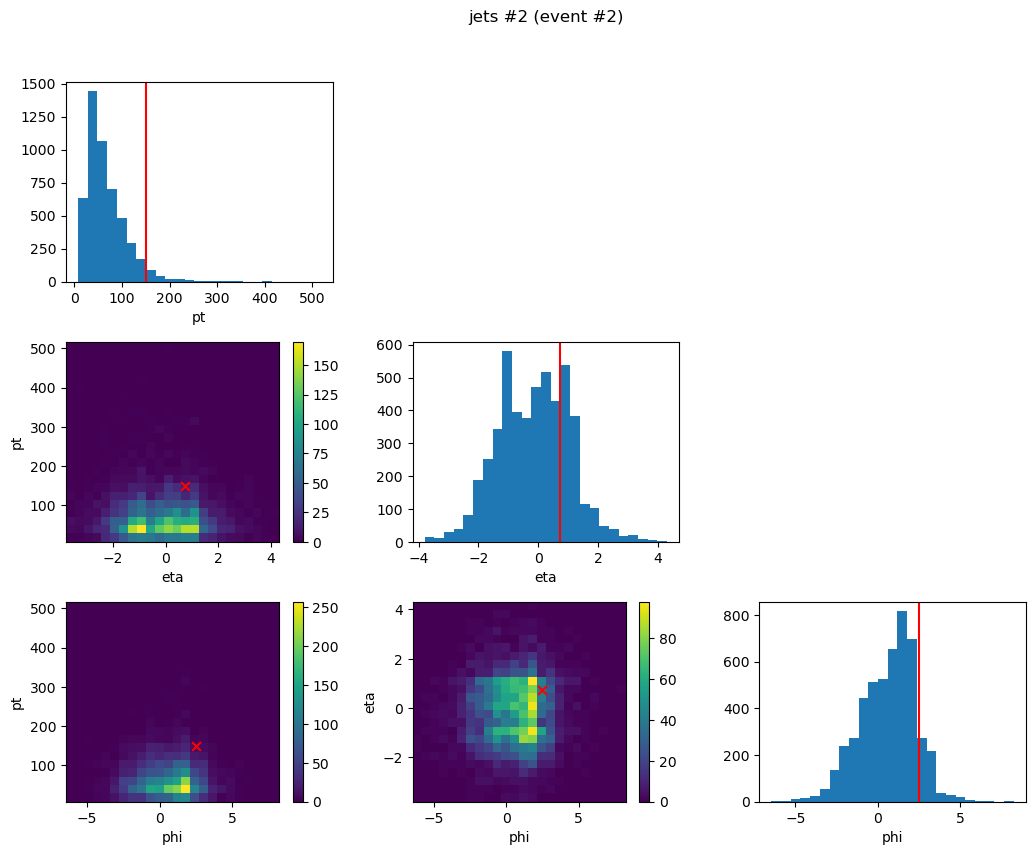

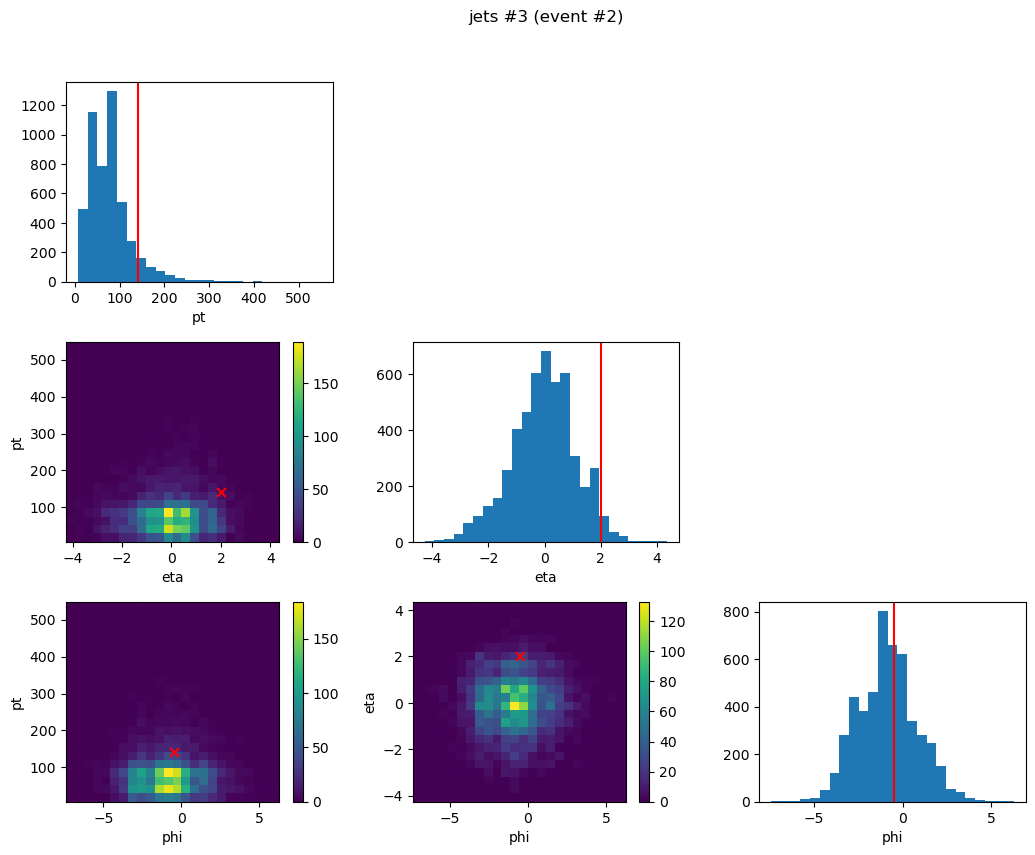

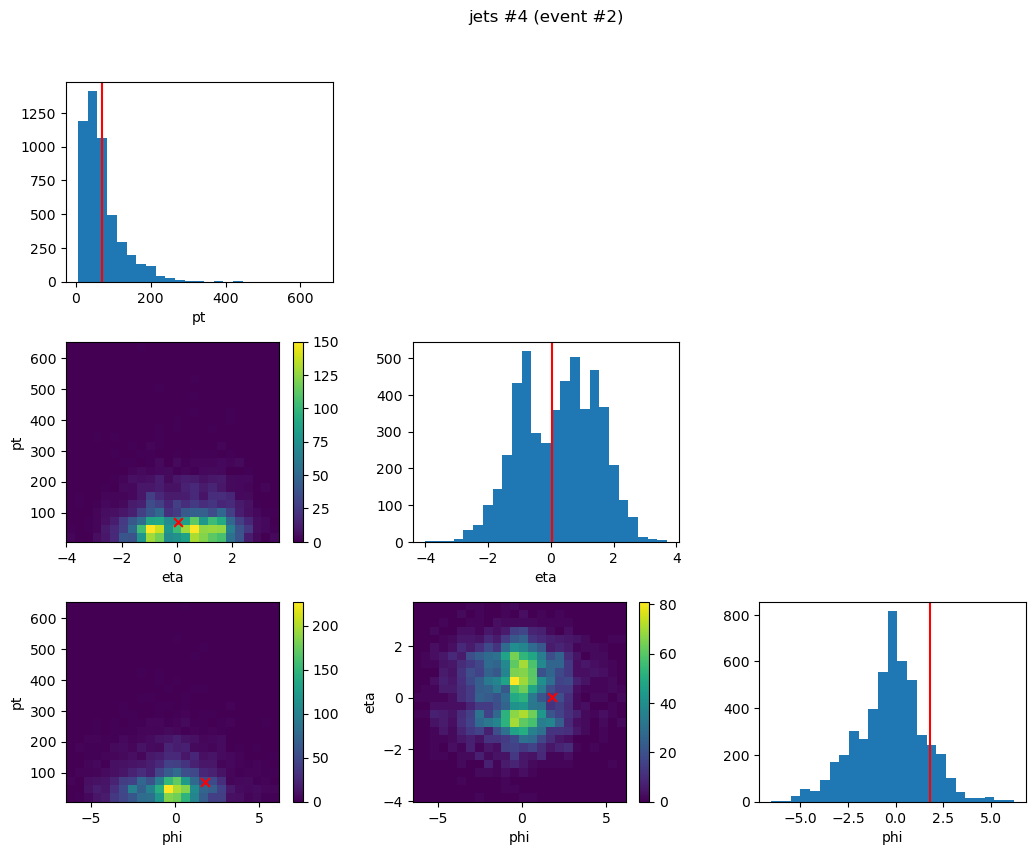

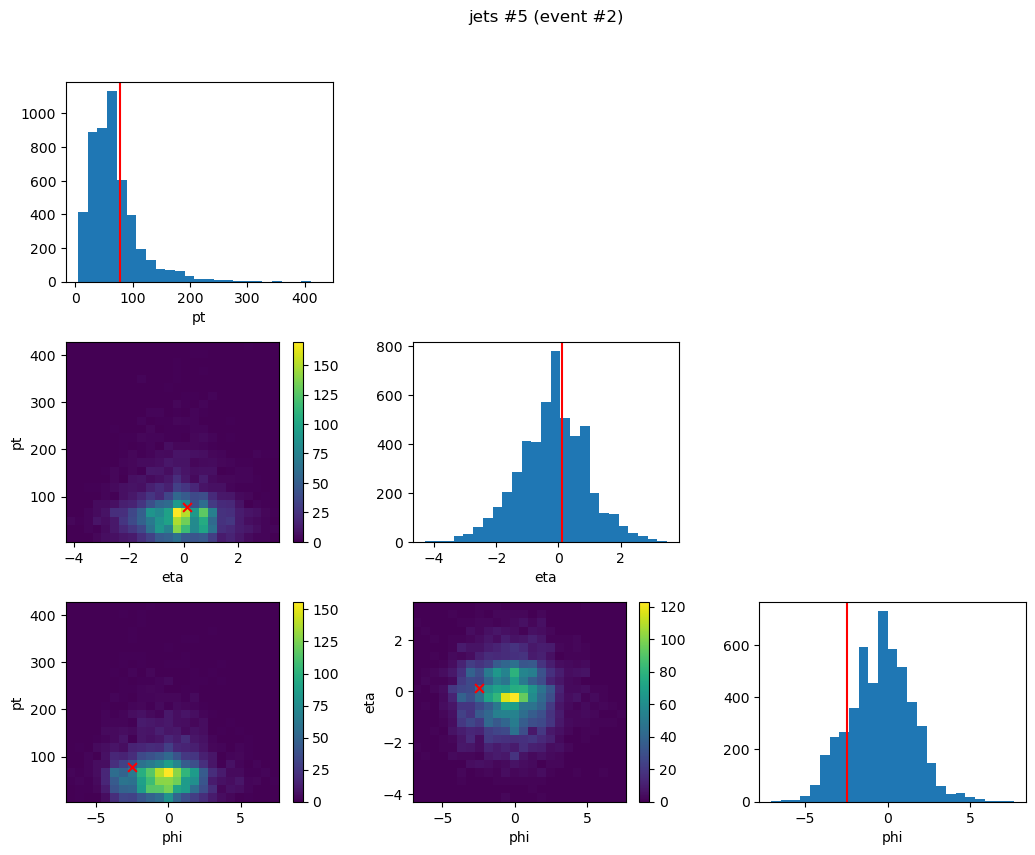

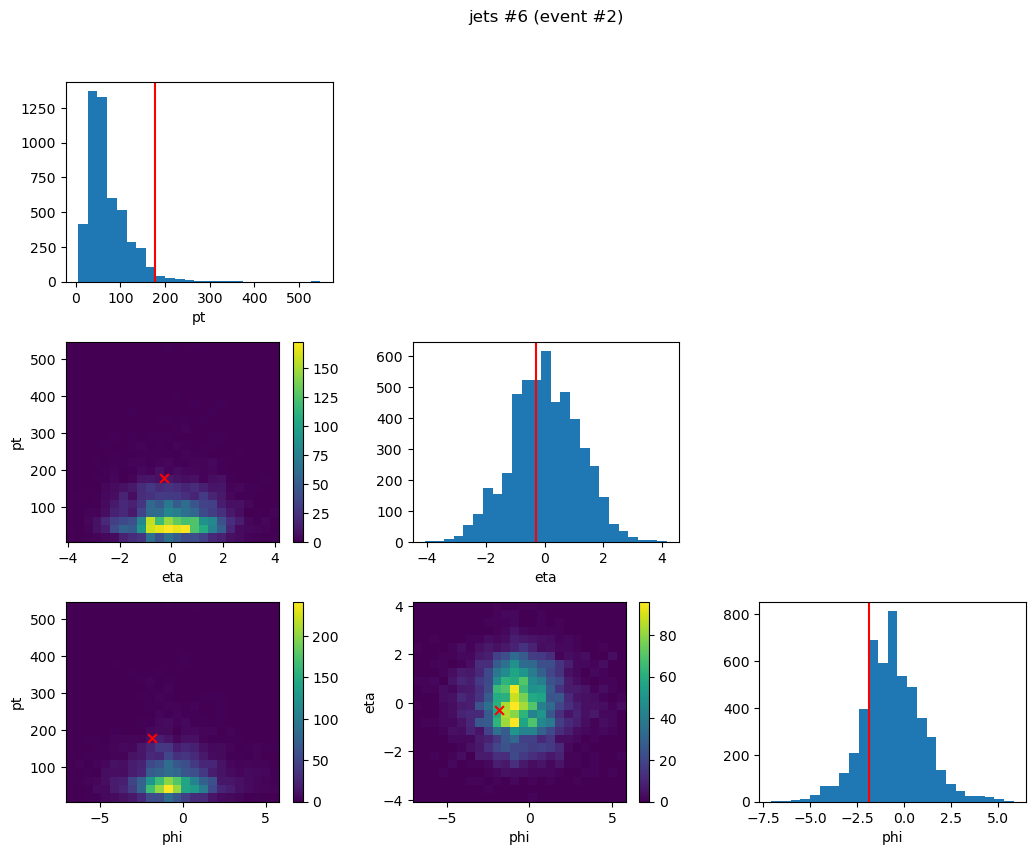

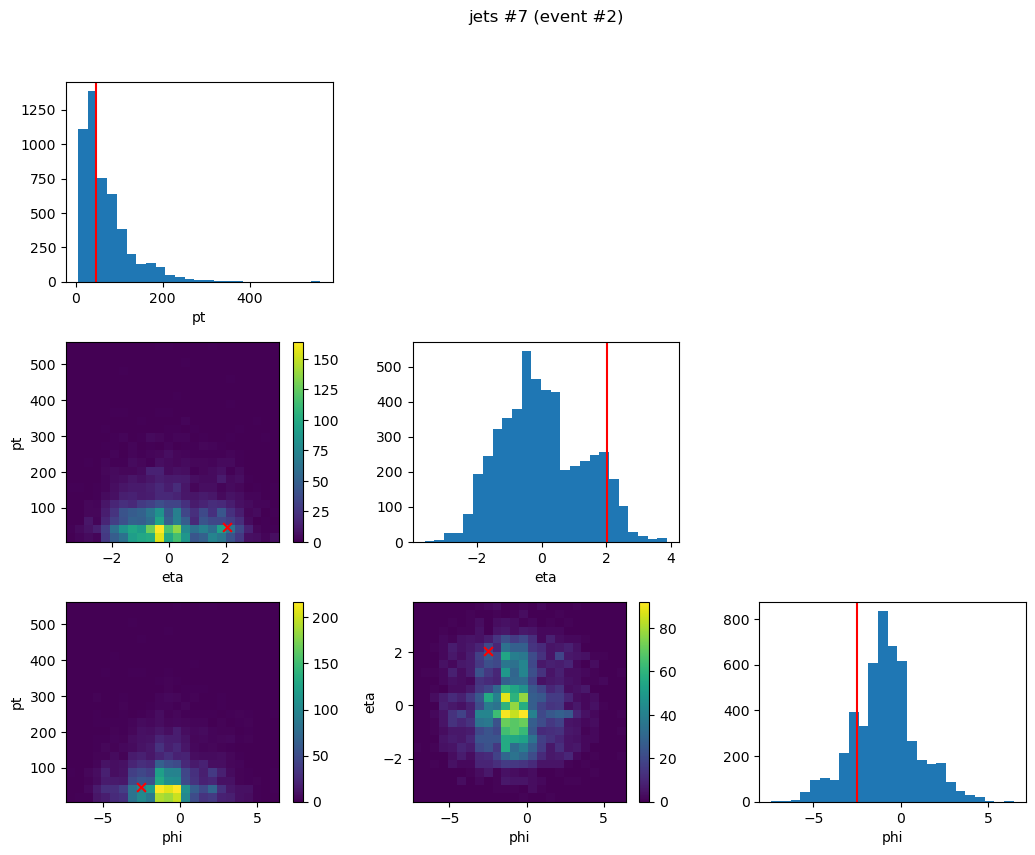

{'event_0_obj_electrons_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_electrons_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_0_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_2': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_3': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_4': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_5': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_6': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_7': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_1_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_2': <Figure siz

In [19]:
sampling = SamplingCallback(
    comb_dataset = comb_dataset,
    idx_to_monitor = idx_to_monitor,
    N_sample = 5000, 
    frequency = 1,
    raw = True,
    bins = 25,
    log_scale = False,
)

sampling.make_sampling_plots(model,show=True)

In [20]:
##### Parameters #####
epochs = 100
steps_per_epoch_train = math.ceil(len(comb_dataset_train)/loader_comb_train.batch_size)
# steps_per_epoch_valid = math.ceil(len(dataset_valid)/loader_valid.batch_size)

print (f'Training   : Batch size = {loader_comb.batch_size} => {steps_per_epoch_train} steps per epoch')
# print (f'Validation : Batch size = {loader_valid.batch_size} => {steps_per_epoch_valid} steps per epoch')
##### Optimizer #####
optimizer = optim.RAdam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.set_optimizer(optimizer)

##### Scheduler #####
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer = optimizer, 
    max_lr = 1e-3, 
    epochs = epochs, 
    steps_per_epoch = steps_per_epoch_train, 
    pct_start = 0.20, 
    anneal_strategy='cos', 
    cycle_momentum=True, 
    base_momentum=0.85, 
    max_momentum=0.95, 
    div_factor=1e3, 
    final_div_factor=1e5,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
    sampling,
] 

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'model',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_comb_train,
    val_dataloaders = loader_comb_valid,
)



Training   : Batch size = 256 => 15 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/f83a799e189b4dbd81ae468a9e6e4ebe

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))
COMET ERROR: File upload failed: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='www.comet.com', port=443): Read timed out. (read timeout=900)")), file: /scratch/fbury/52221033/tmphbkqpqk0.svg, url: 'https://www.comet.com/clientlib/visualizations/upload', max retries: 4


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))
COMET ERROR: File upload failed: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='www.comet.com', port=443): Read timed out. (read timeout=900)")), file: /scratch/fbury/52221033/tmpgj1d517n.svg, url: 'https://www.comet.com/clientlib/visualizations/upload', max retries: 4


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))
COMET ERROR: File upload failed: ReadTimeout(ReadTimeoutError("HTTPSConnectionPool(host='www.comet.com', port=443): Read timed out. (read timeout=900)")), file: /scratch/fbury/52221033/tmpjlc6ojij.svg, url: 'https://www.comet.com/clientlib/visualizations/upload', max retries: 4


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))


Validation: |                                             | 0/? [00:00<?, ?it/s]

/auto/home/users/f/b/fbury/HHMEM/MEMFlow/memflow/callbacks/transfer_flow_callbacks.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(N,N,figsize=(4*N,3*N))
`Trainer.fit` stopped: `max_epochs=100` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : model
COMET INFO:     url                   : https://www.comet.com/florianbury/mem-flow-hh/f83a799e189b4dbd81ae468a9e6e4ebe
COMET INFO:   Metrics [count] (mi

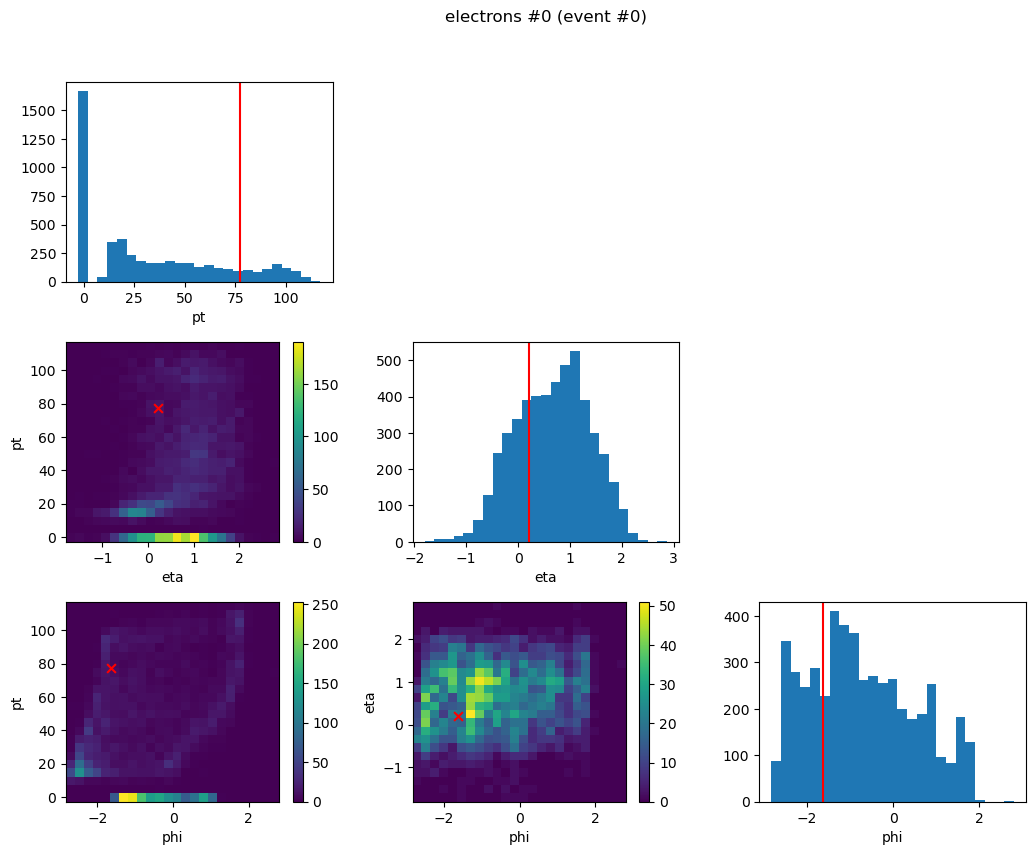

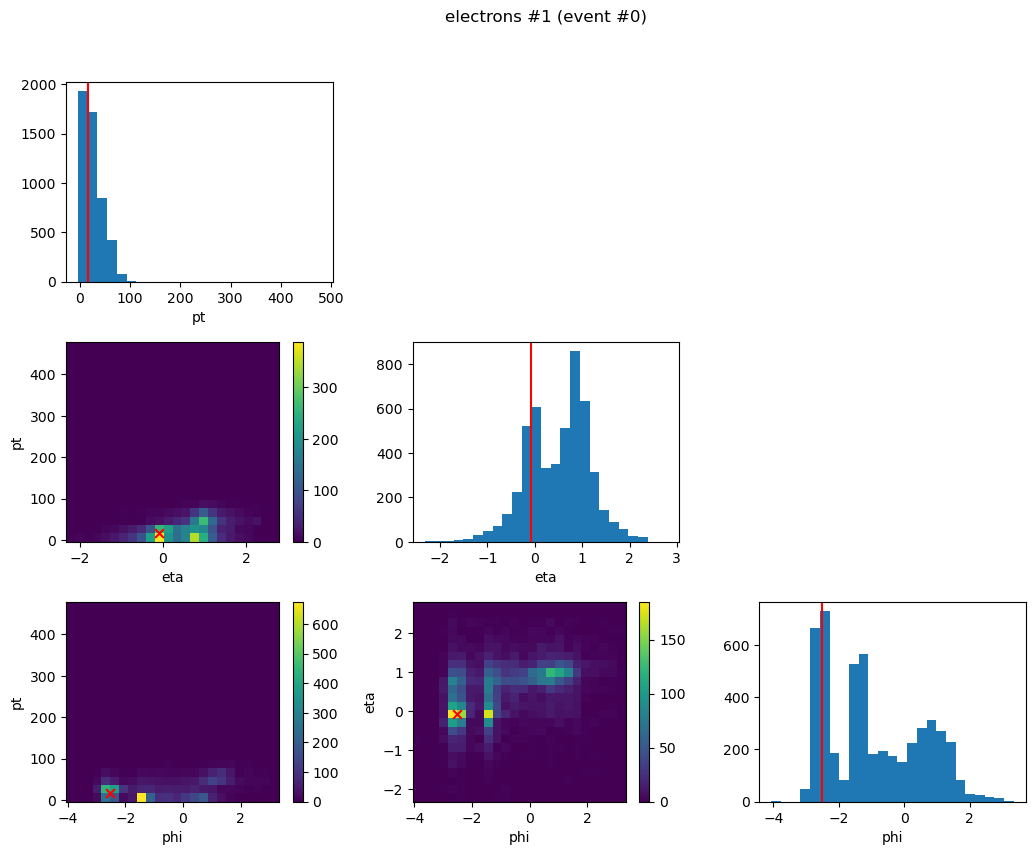

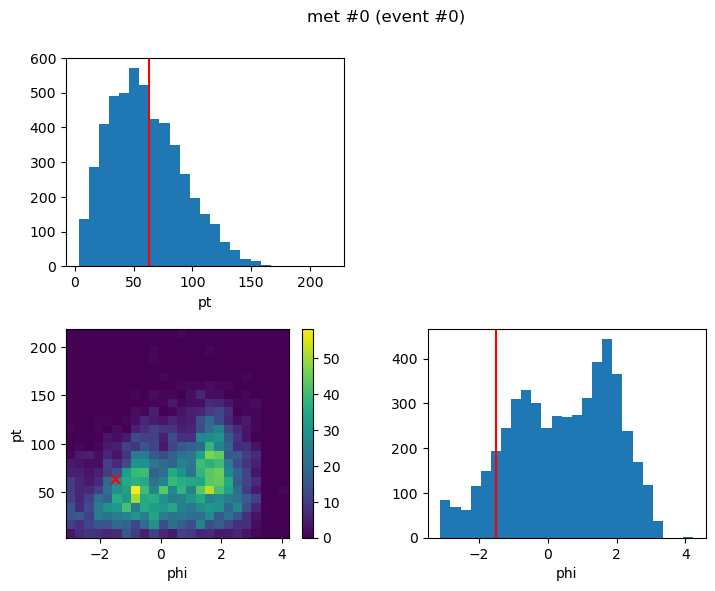

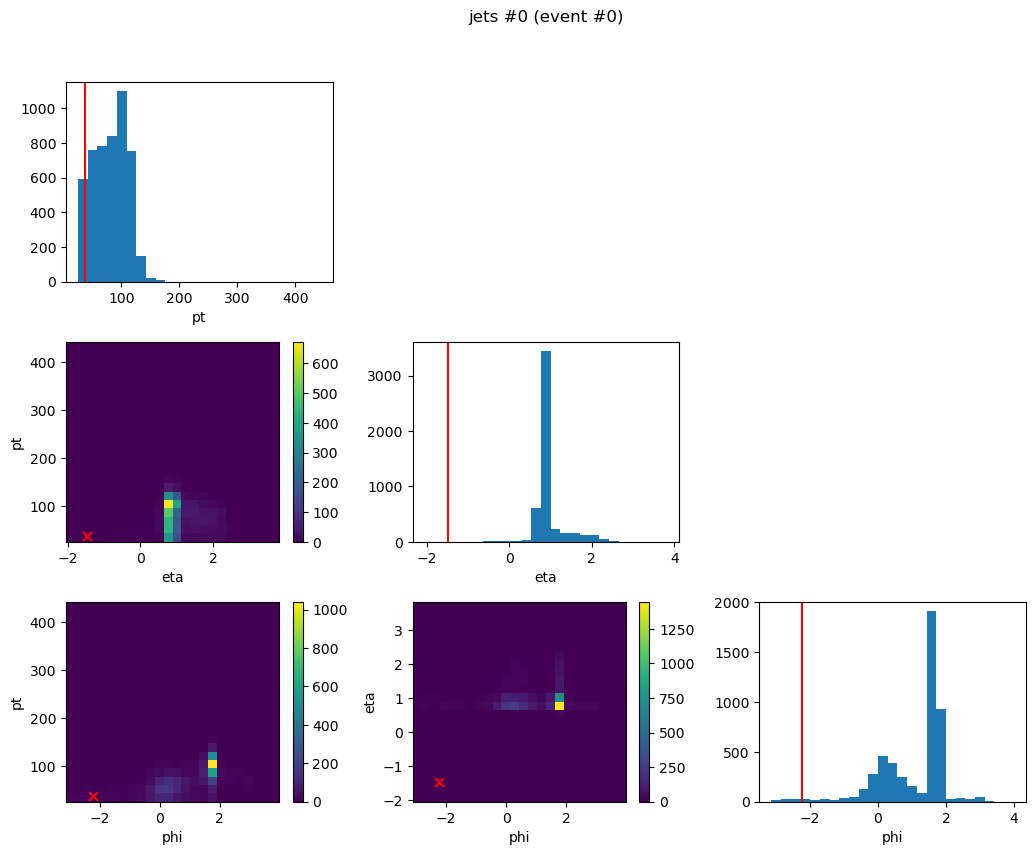

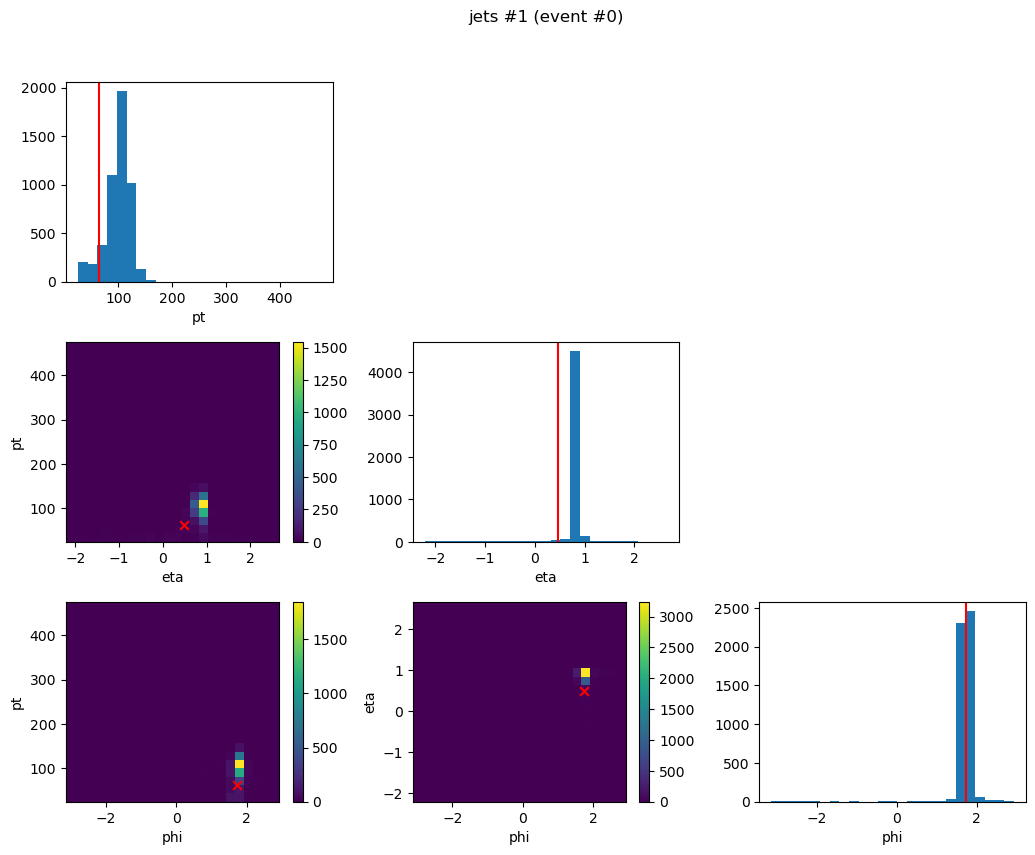

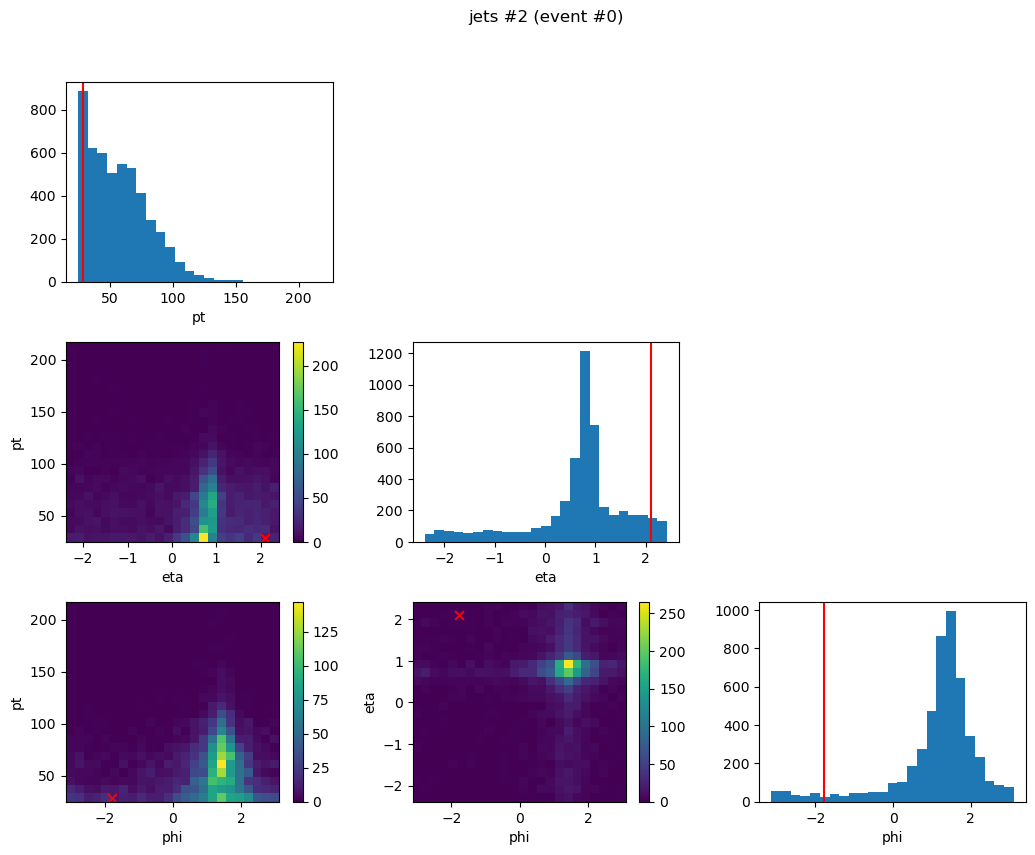

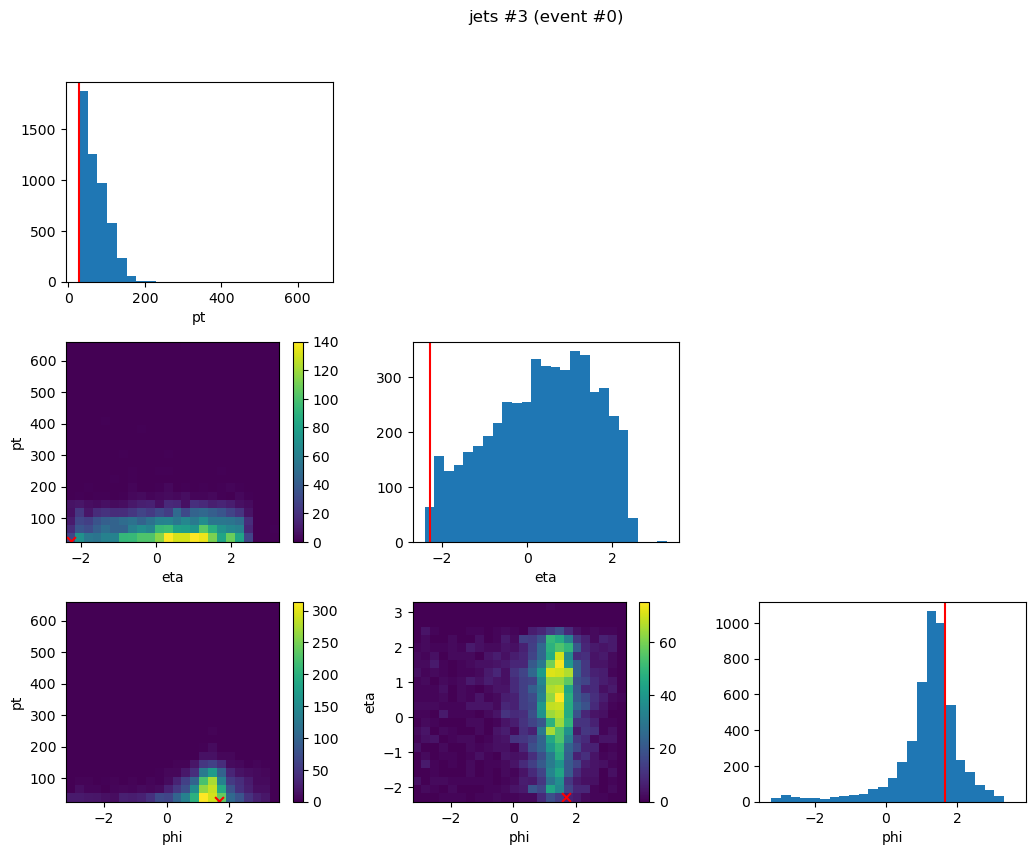

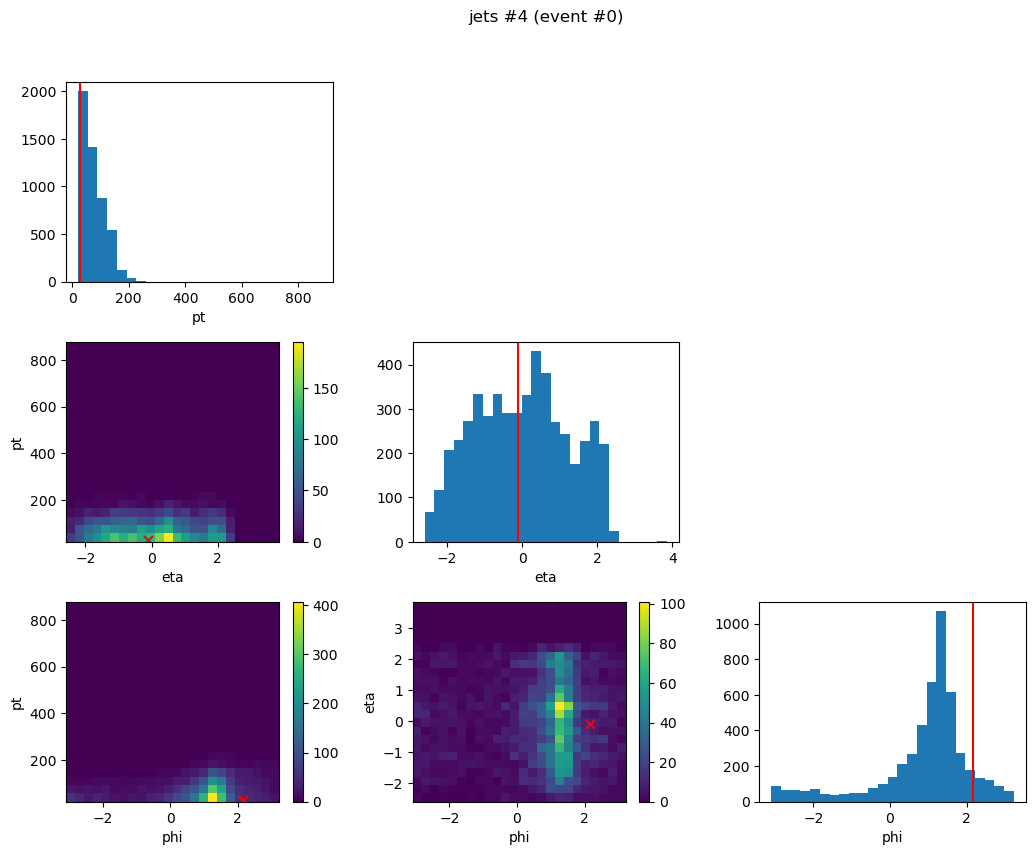

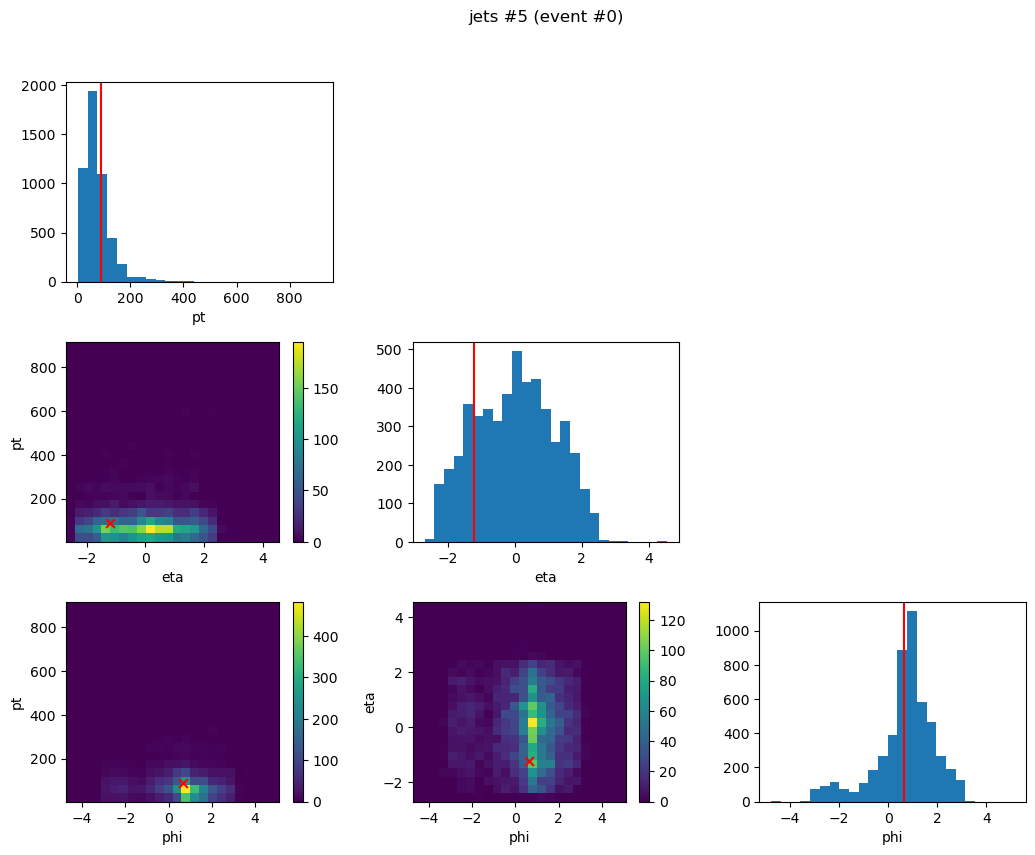

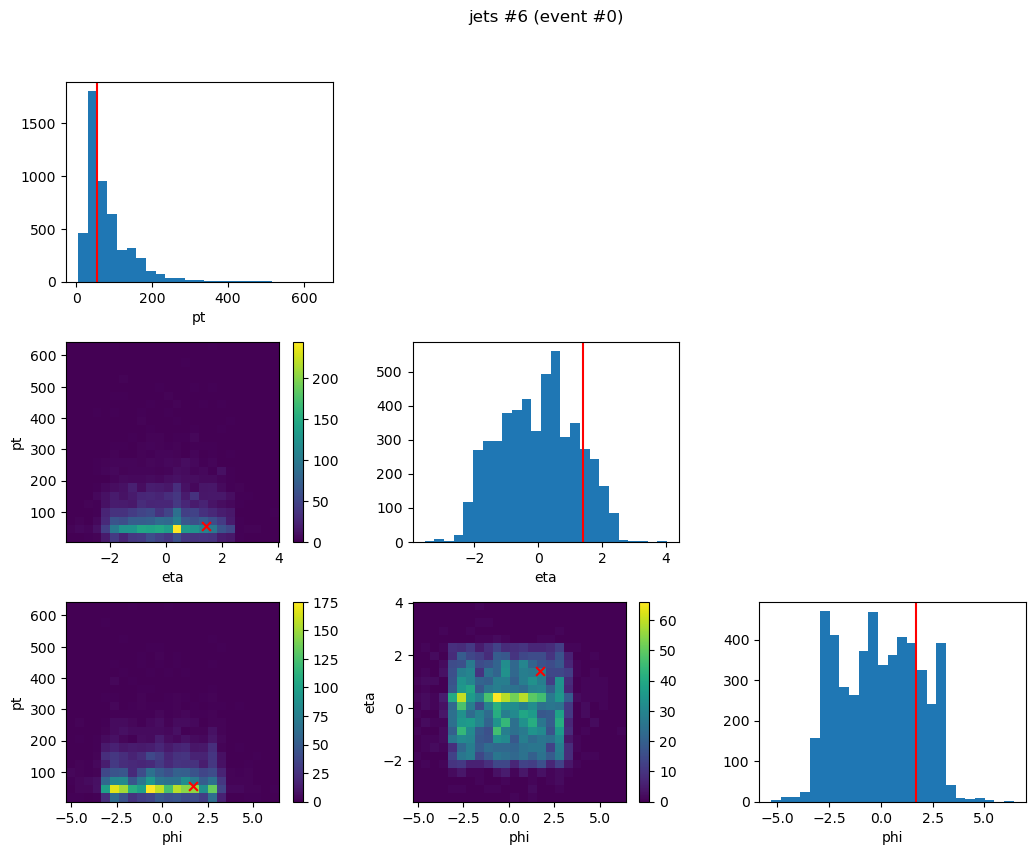

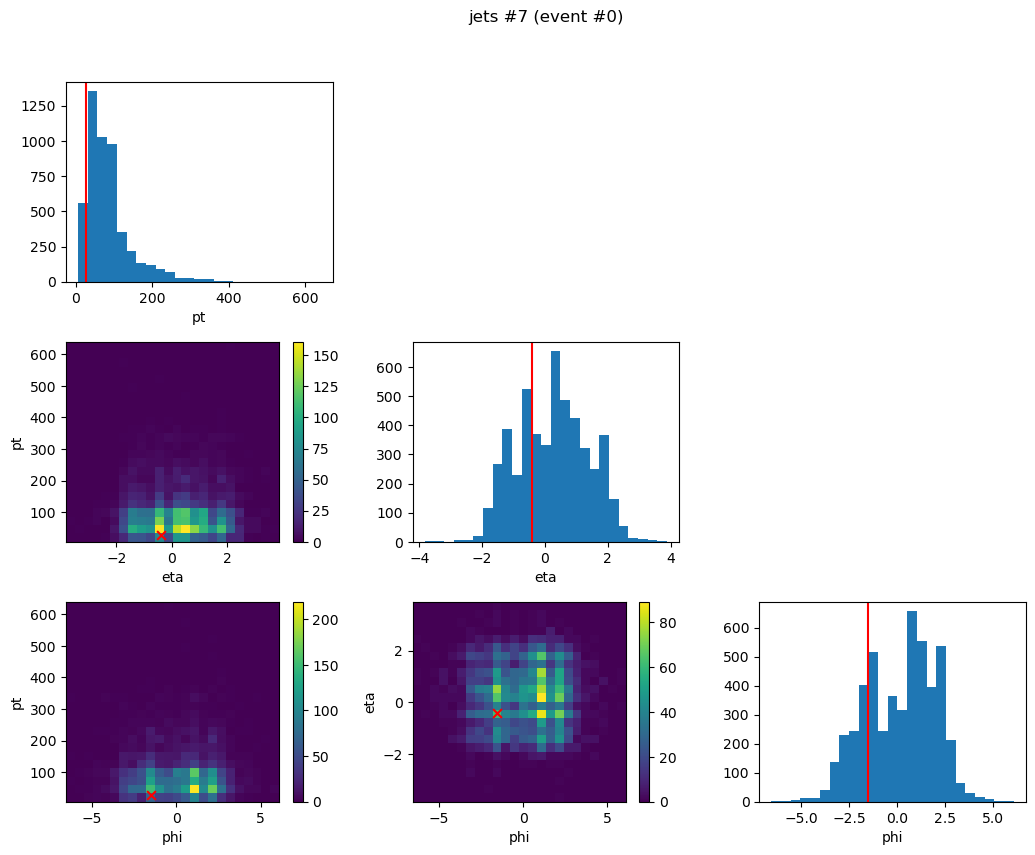

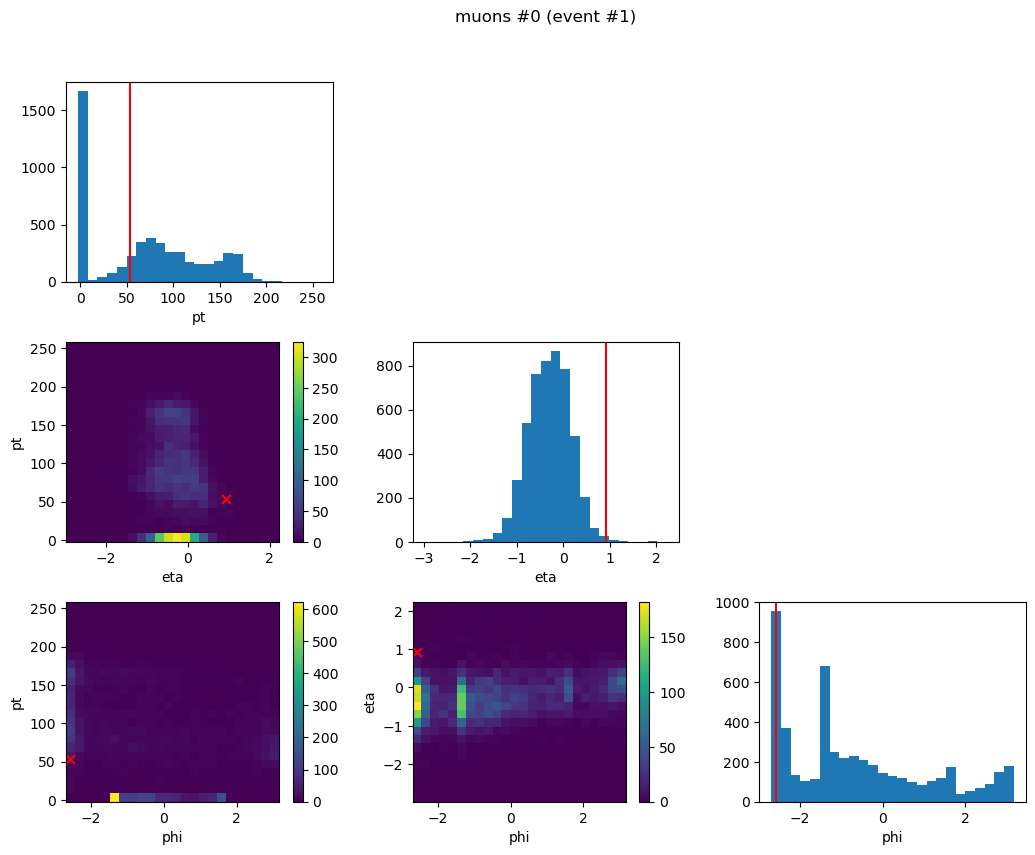

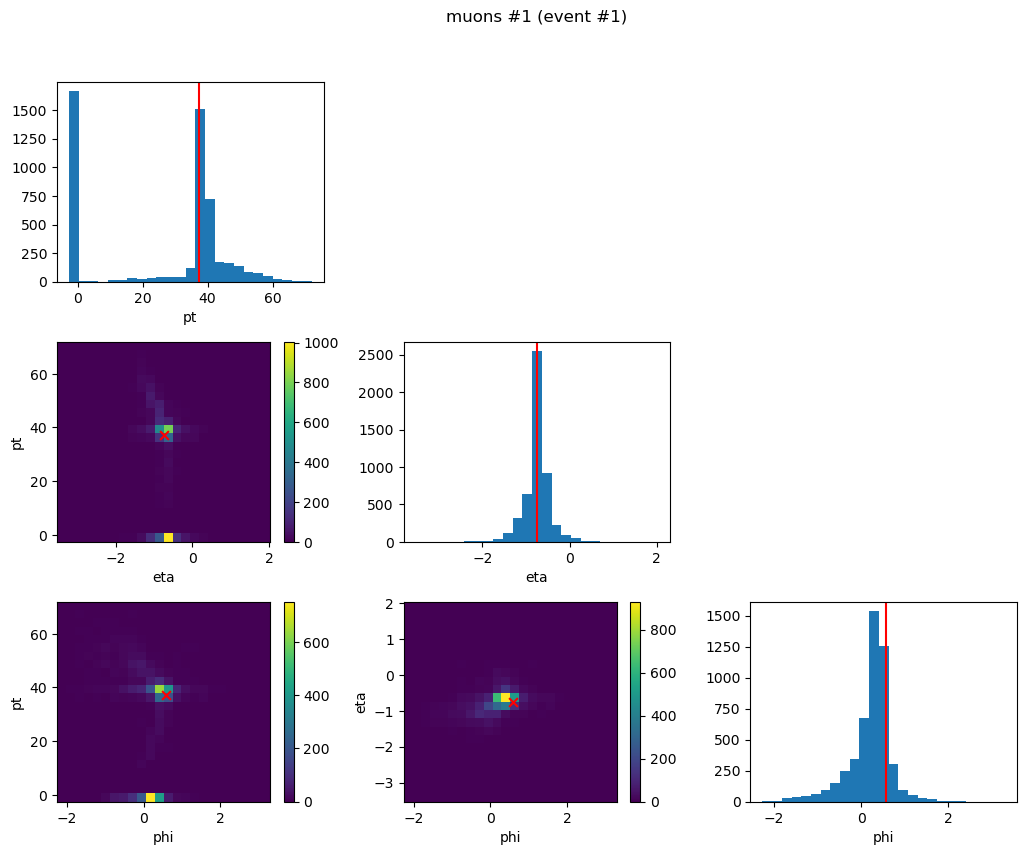

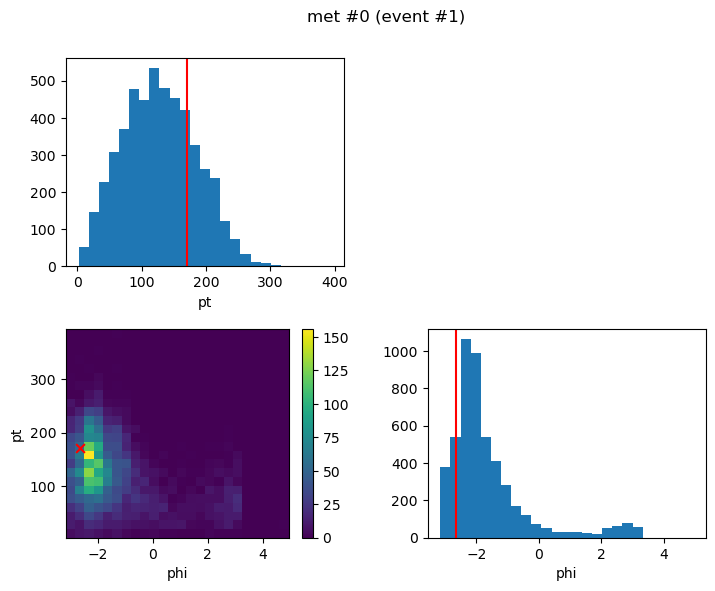

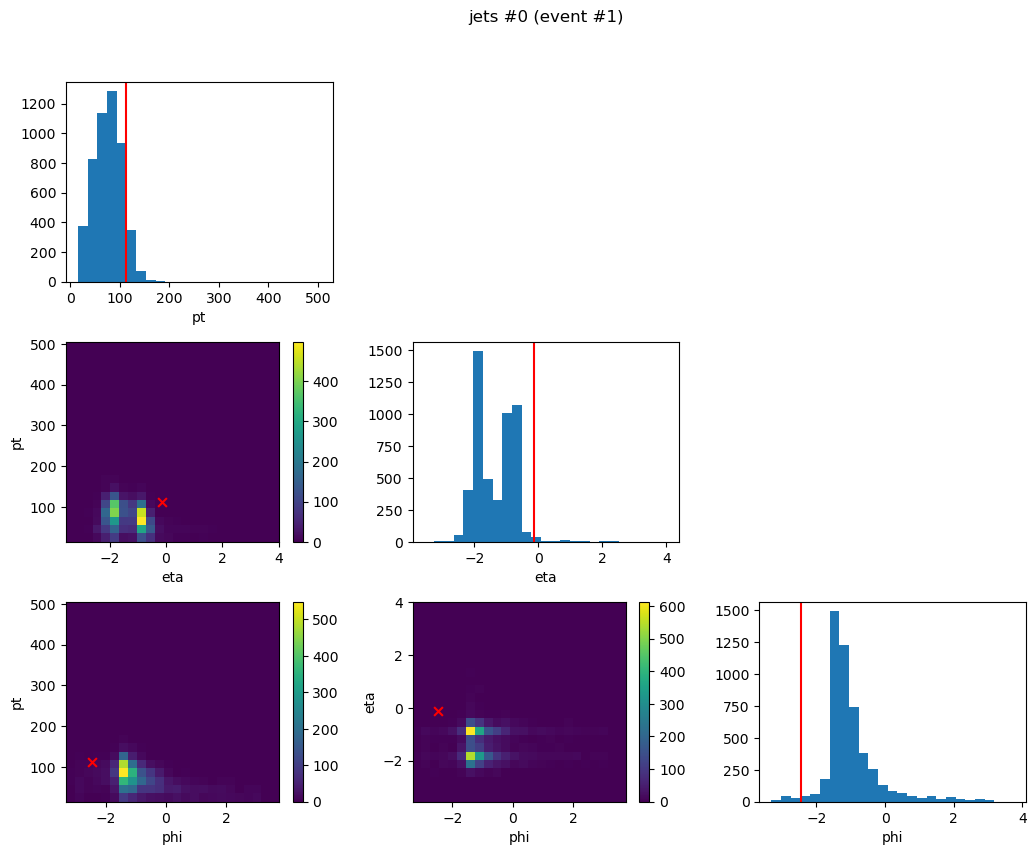

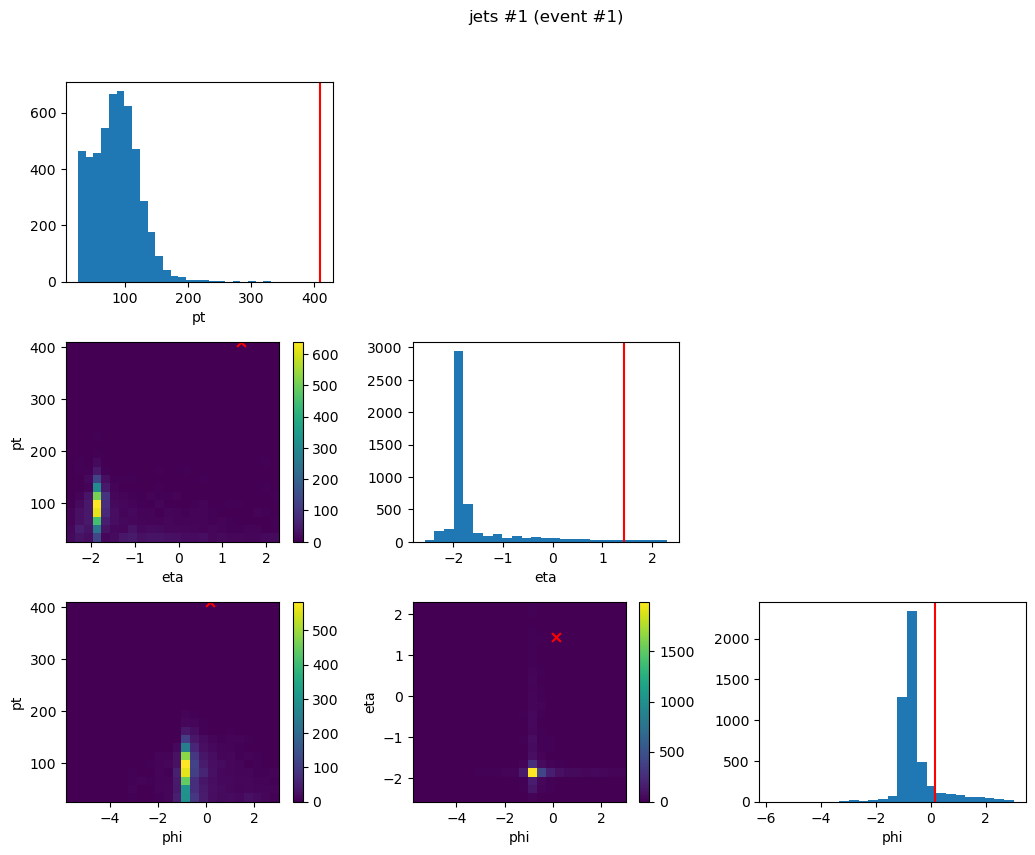

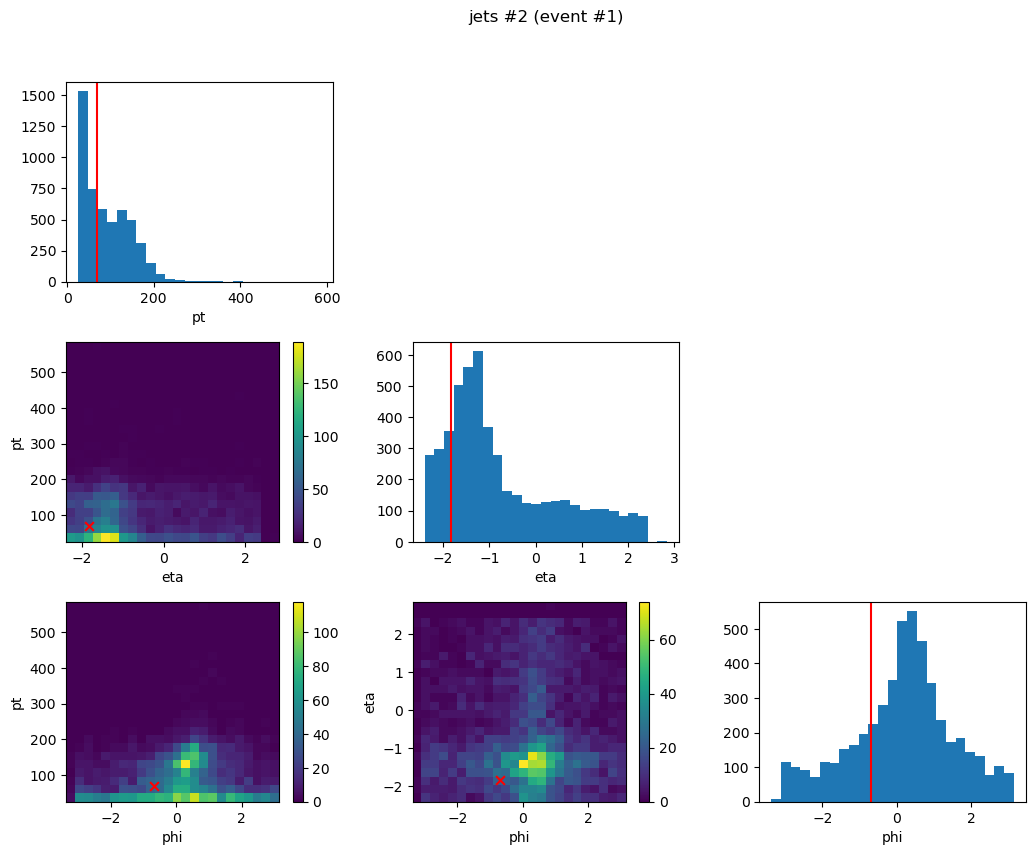

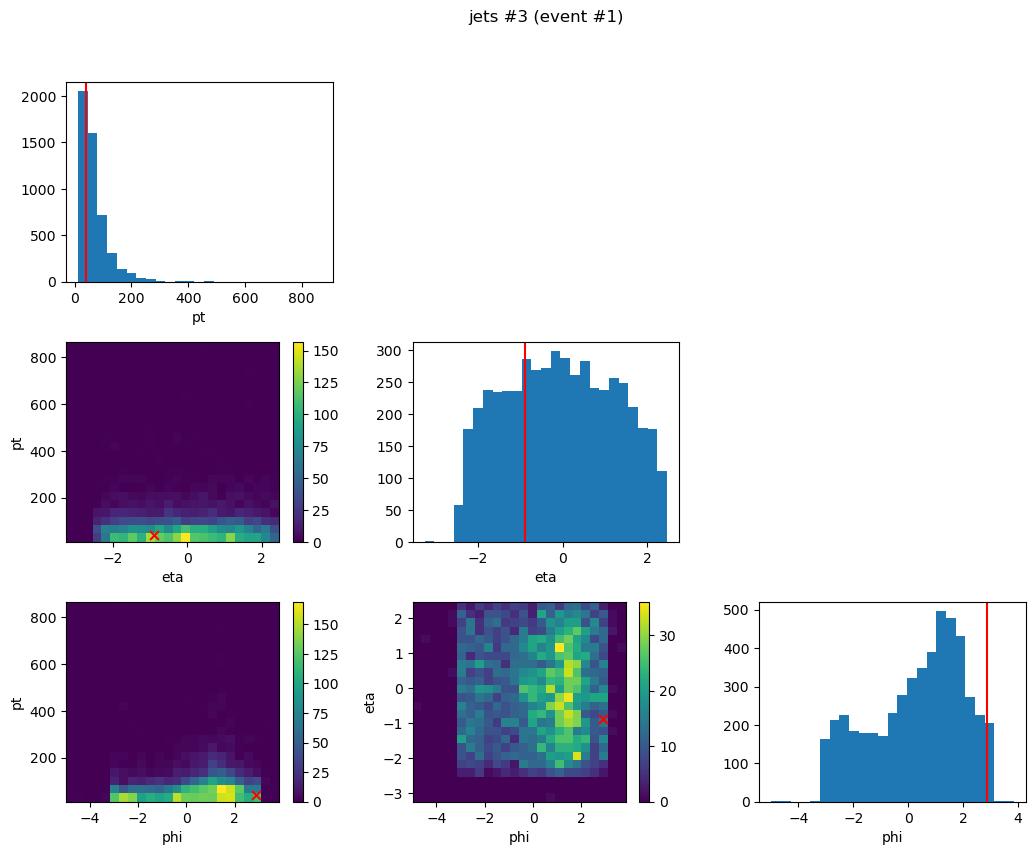

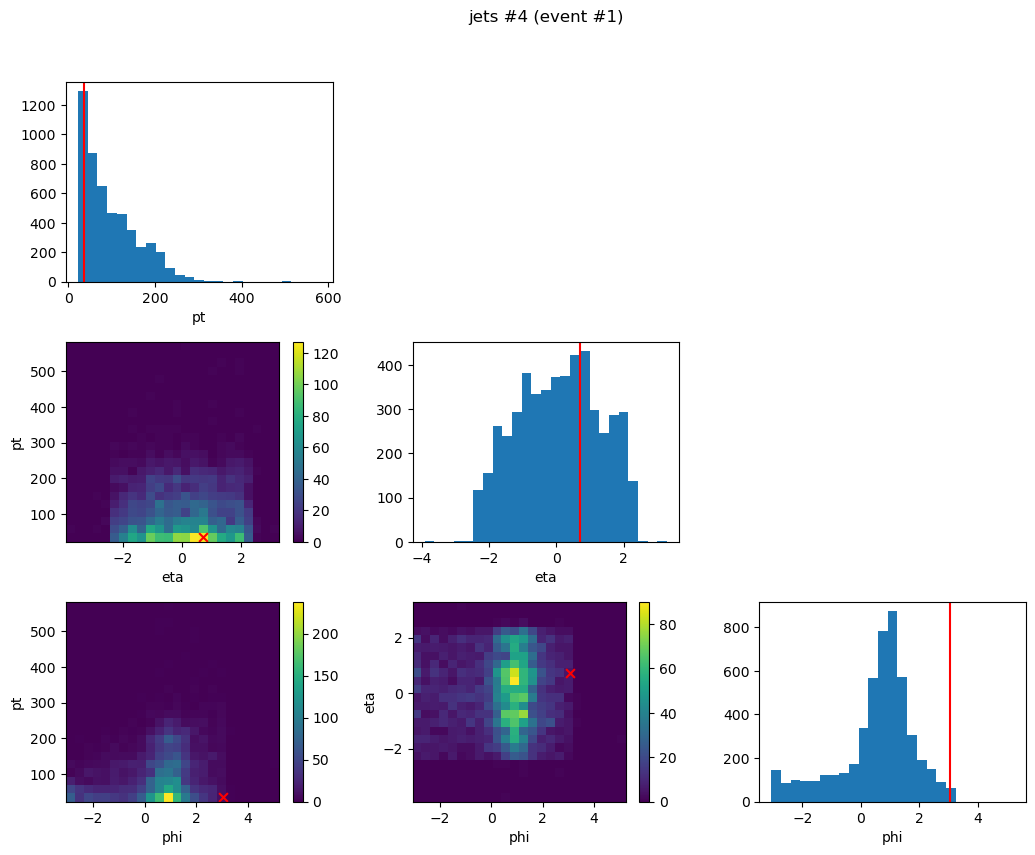

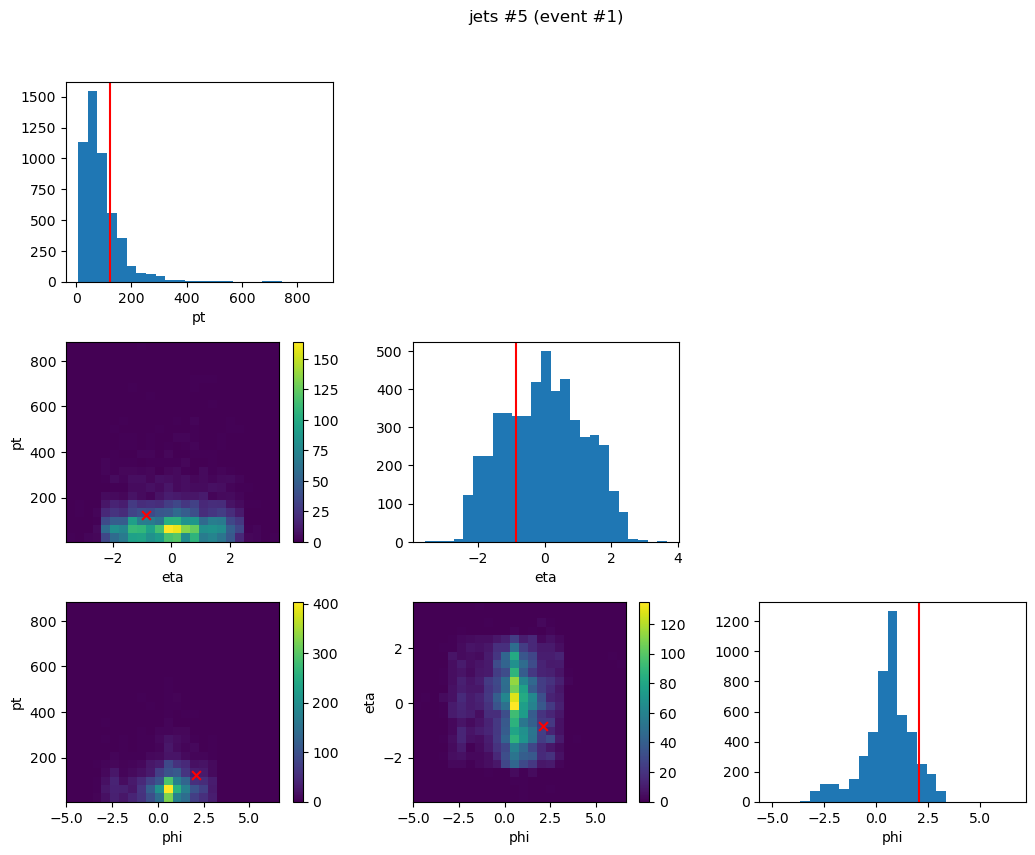

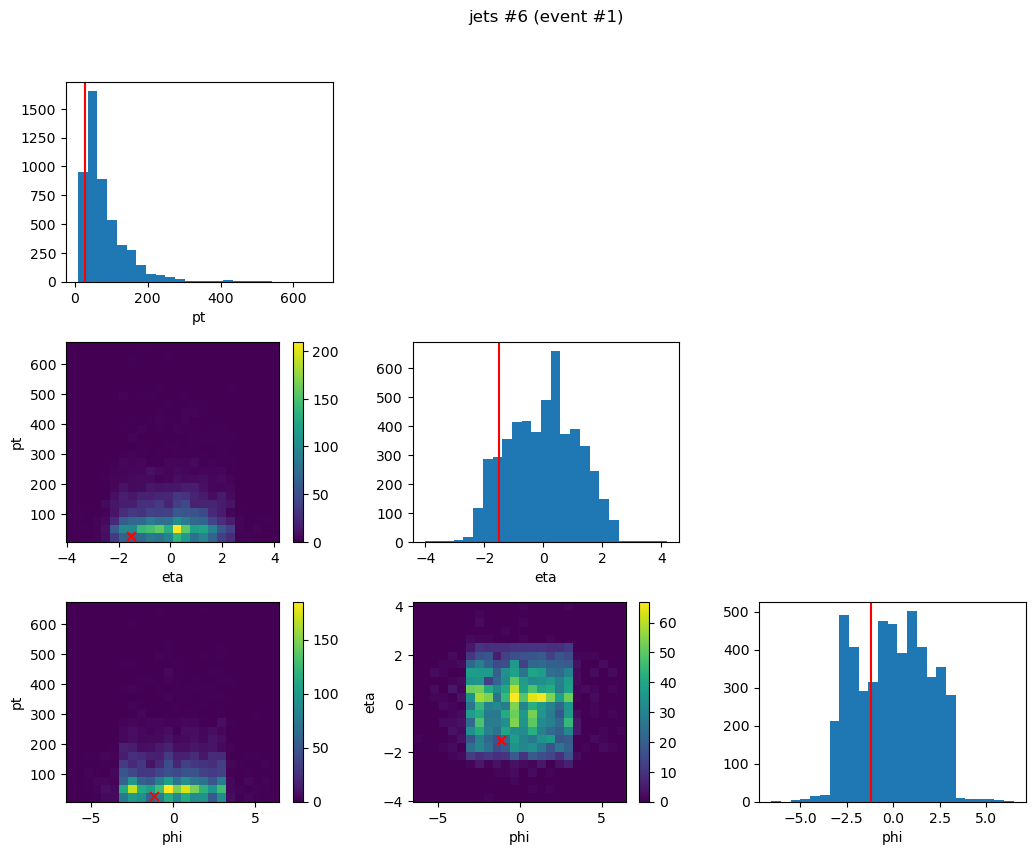

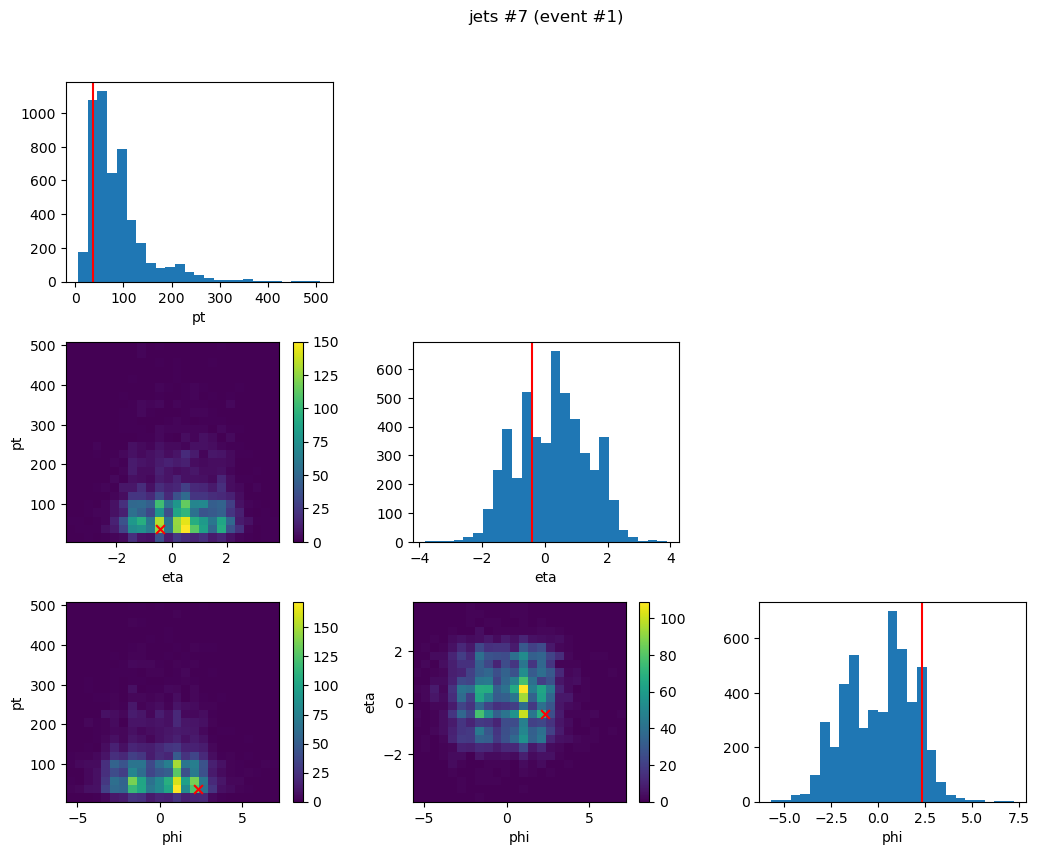

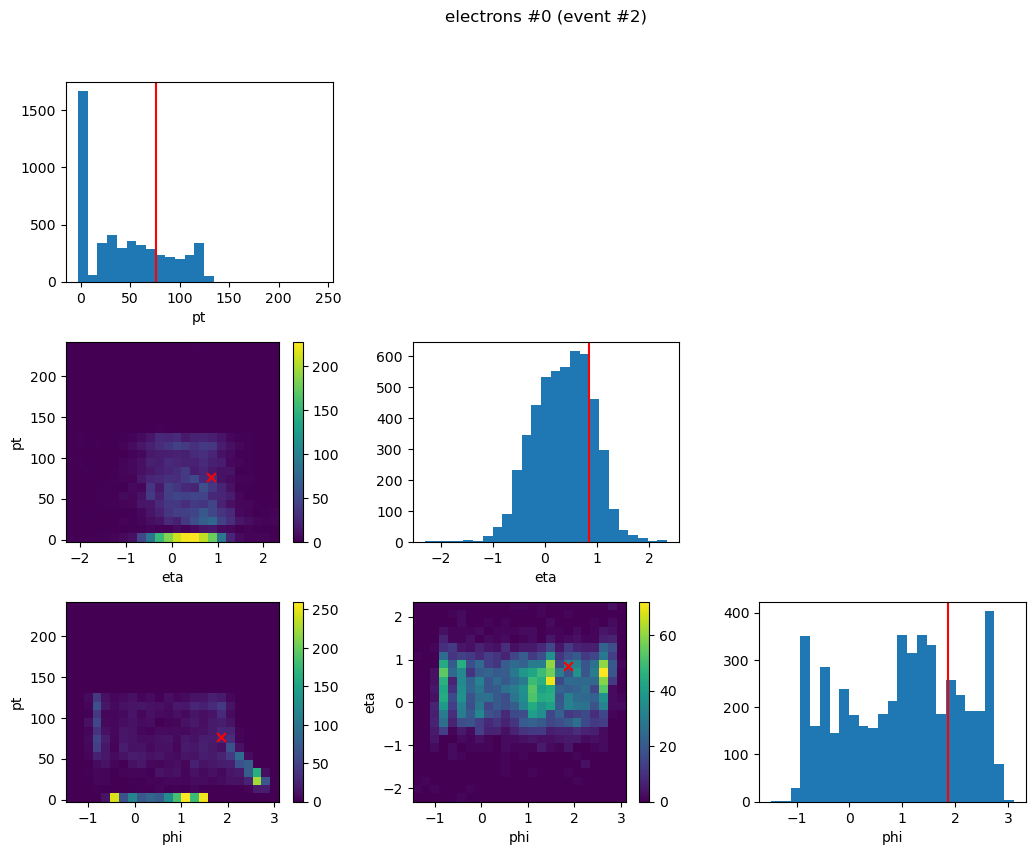

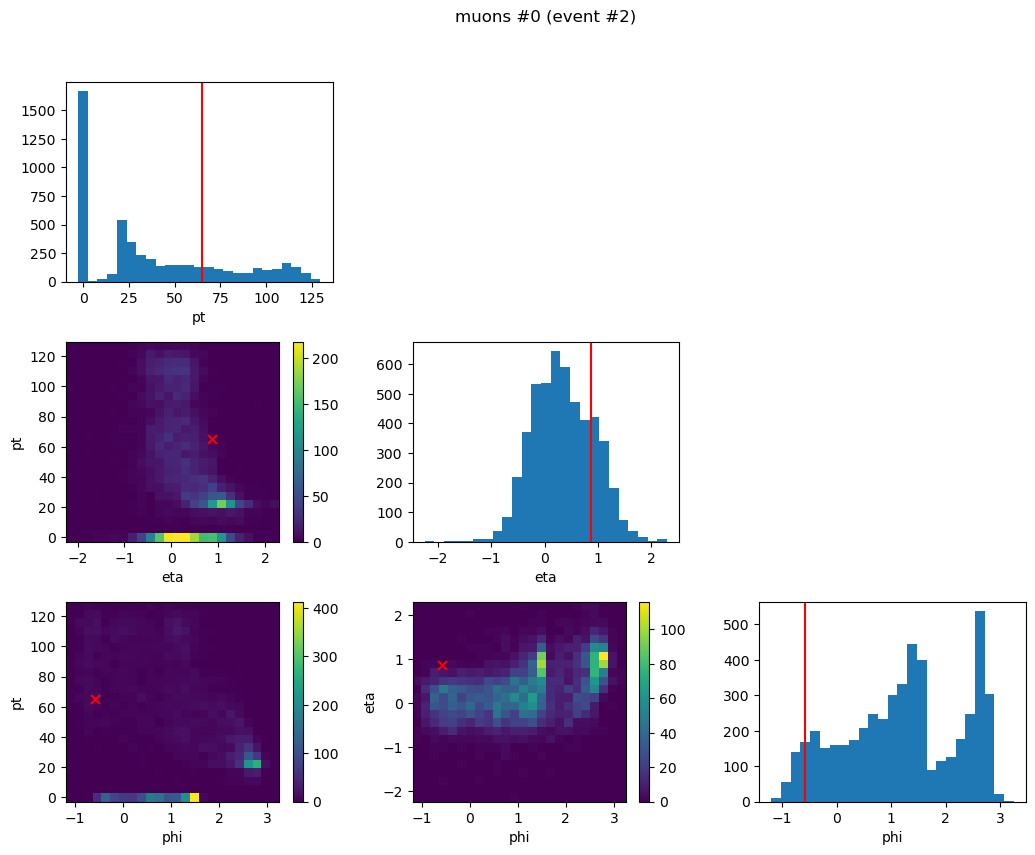

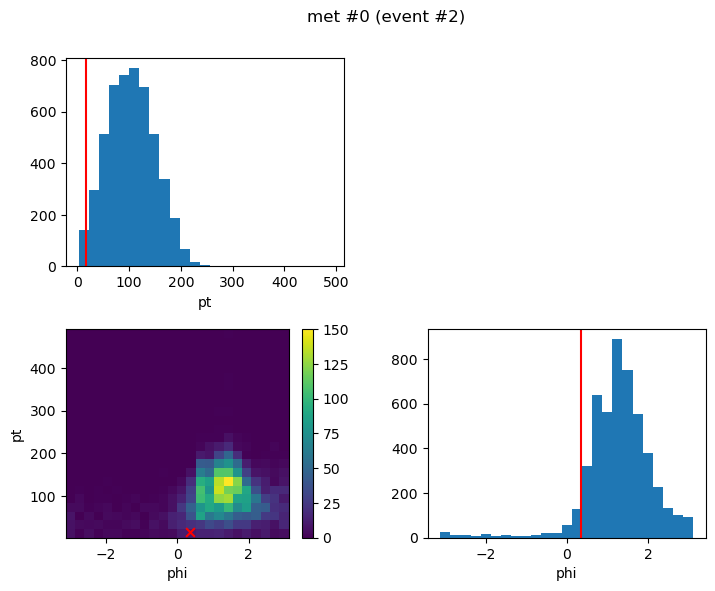

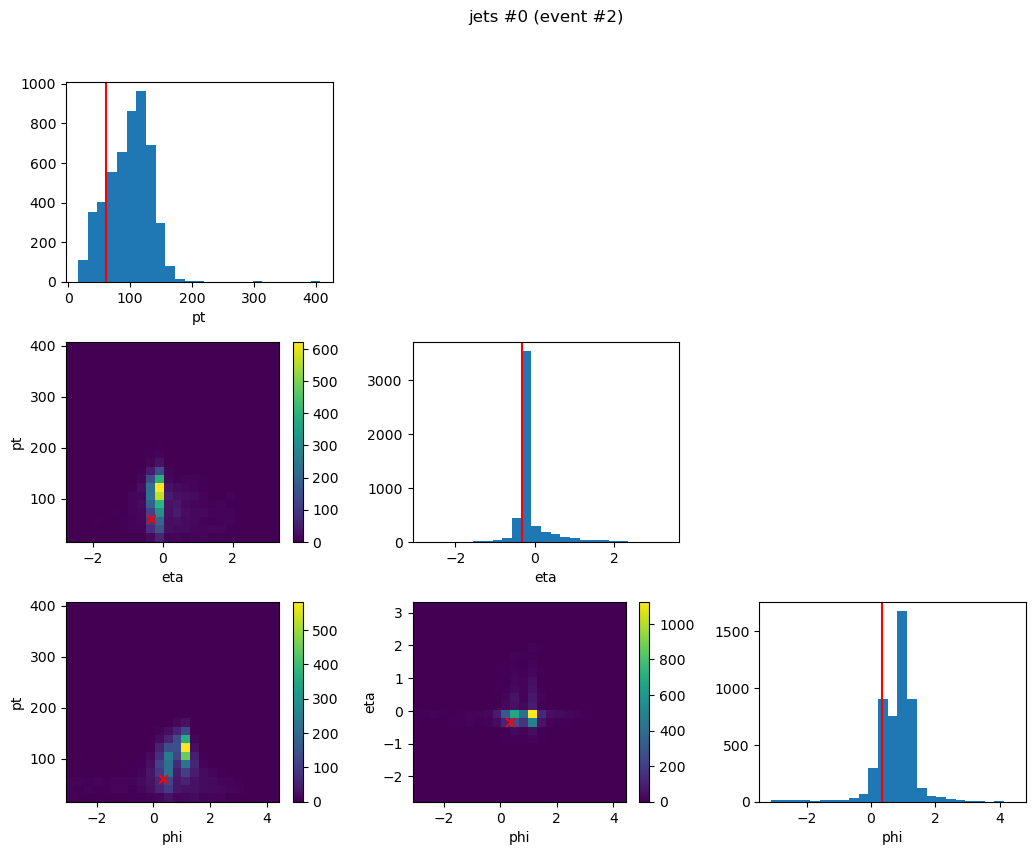

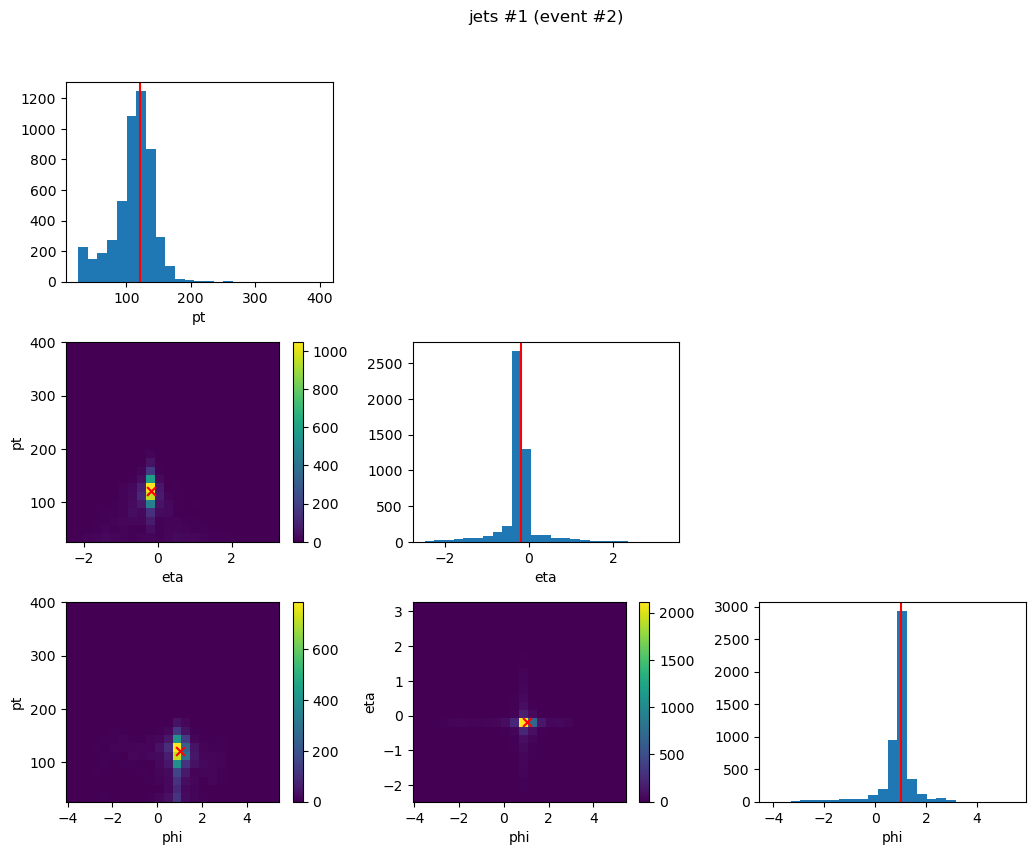

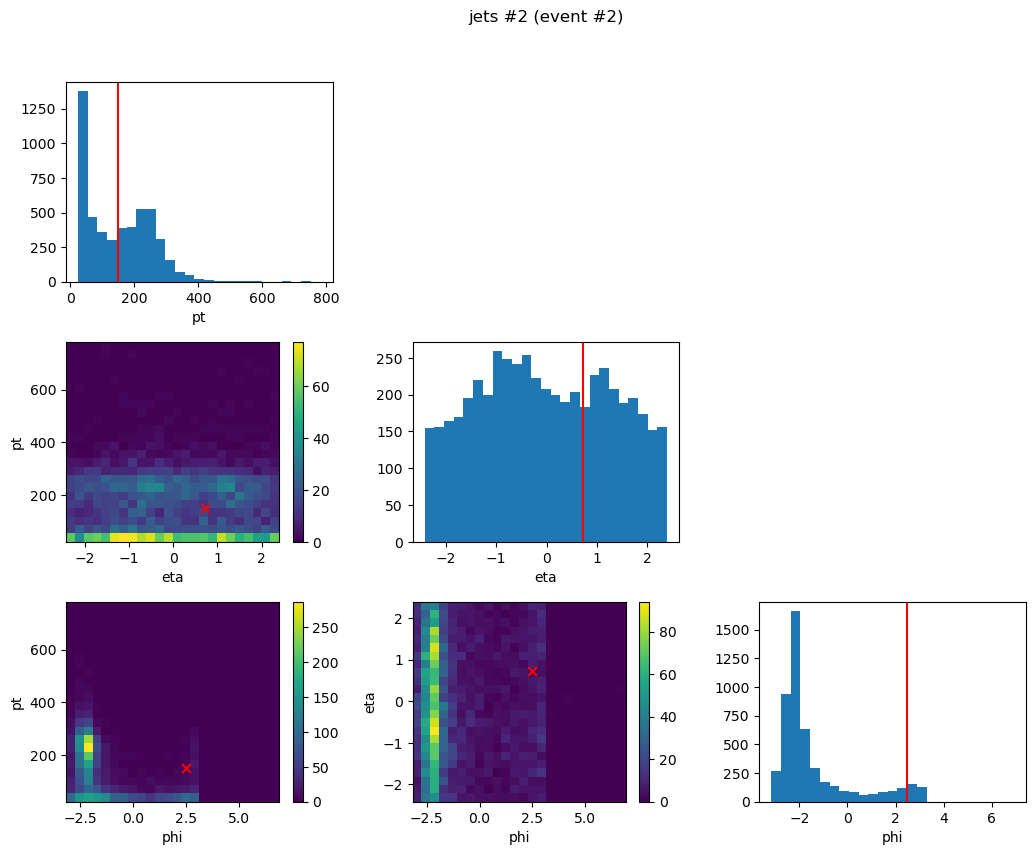

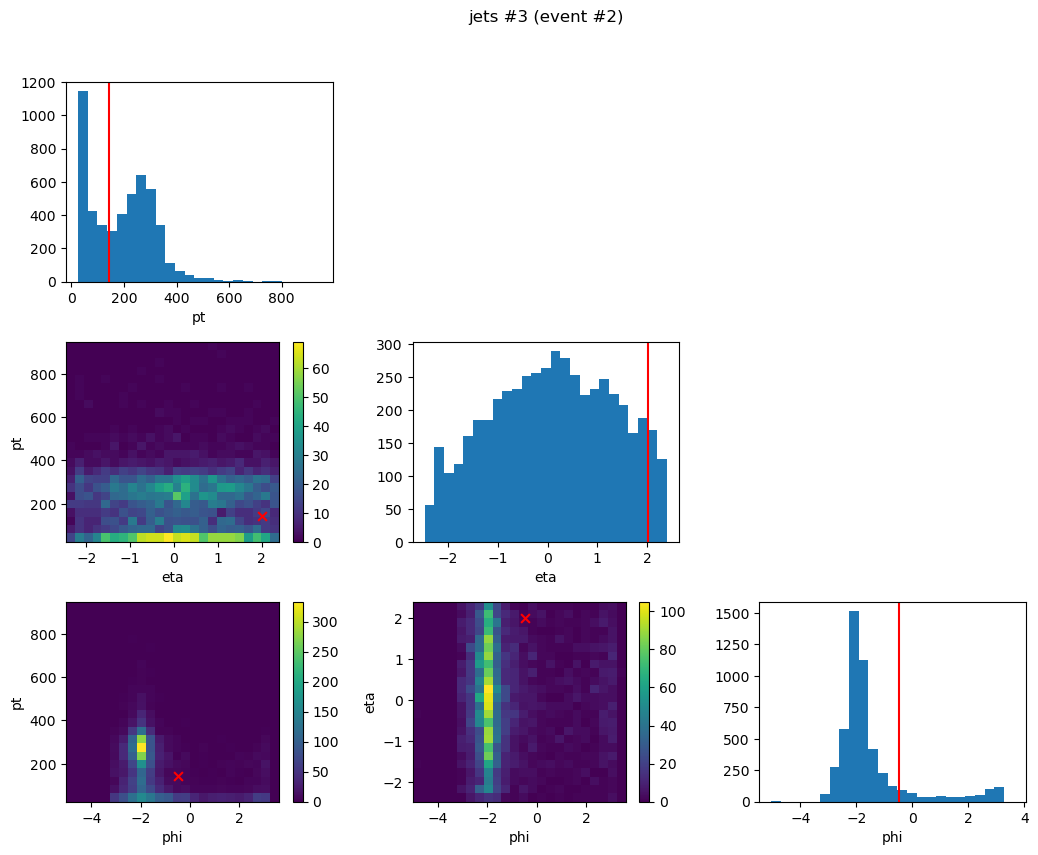

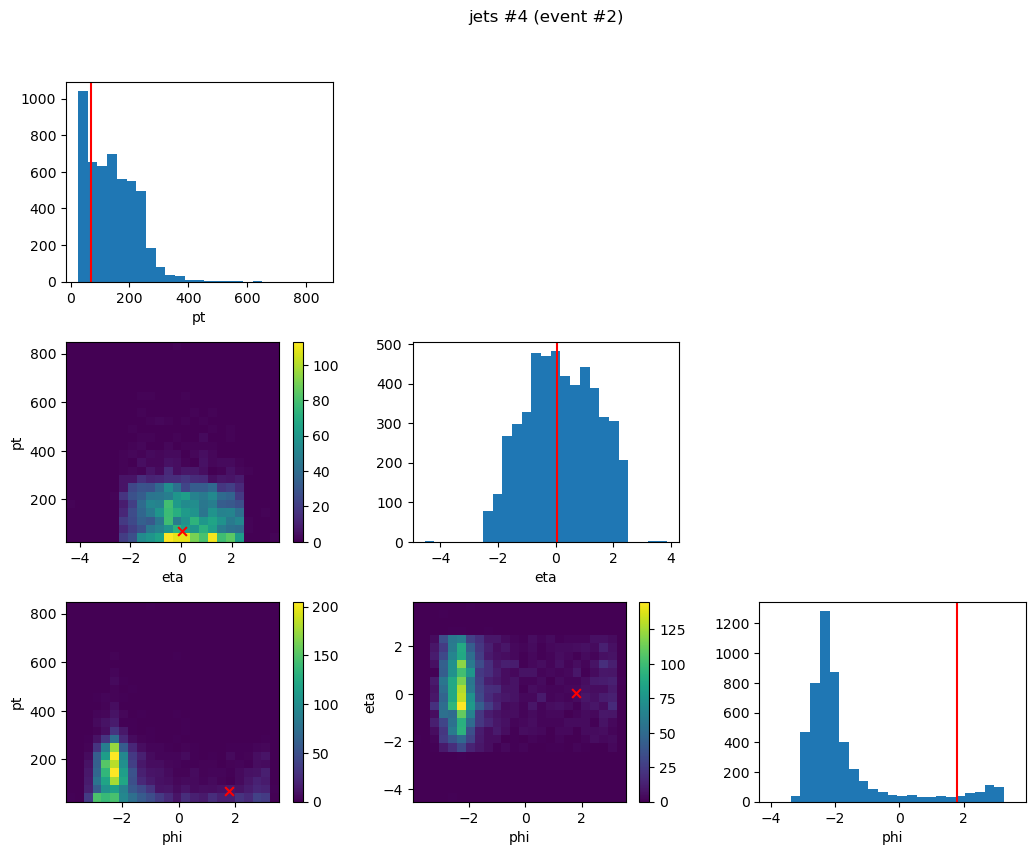

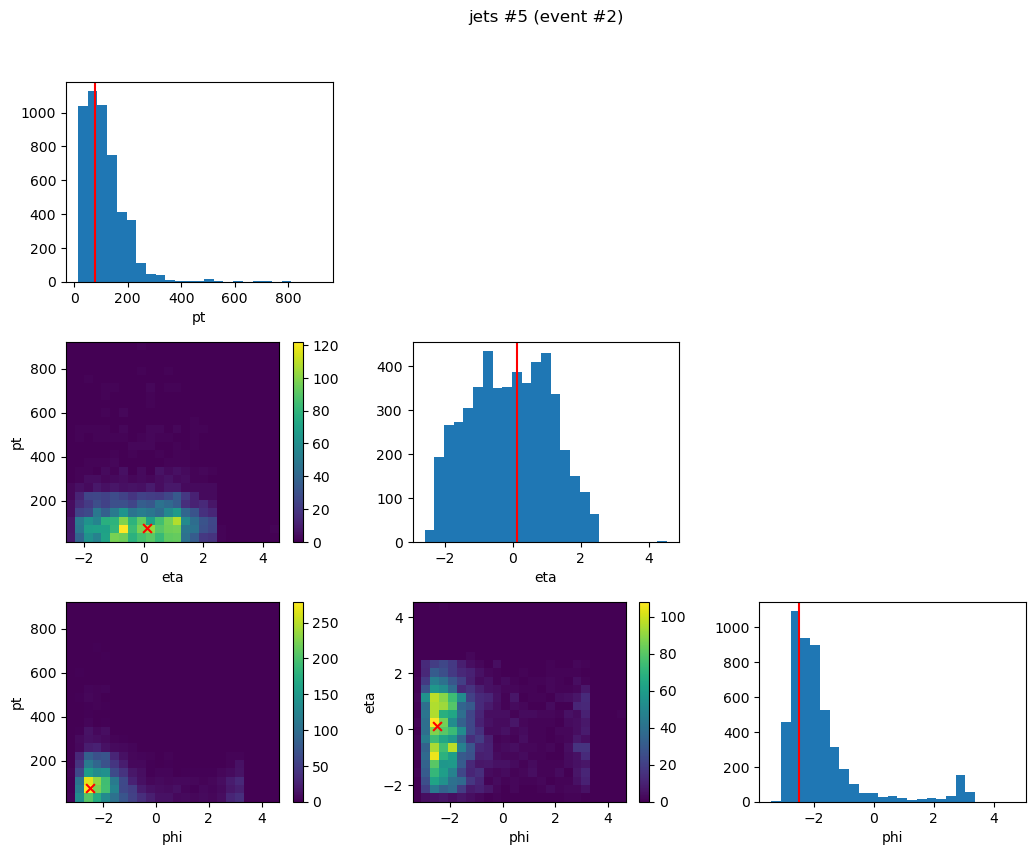

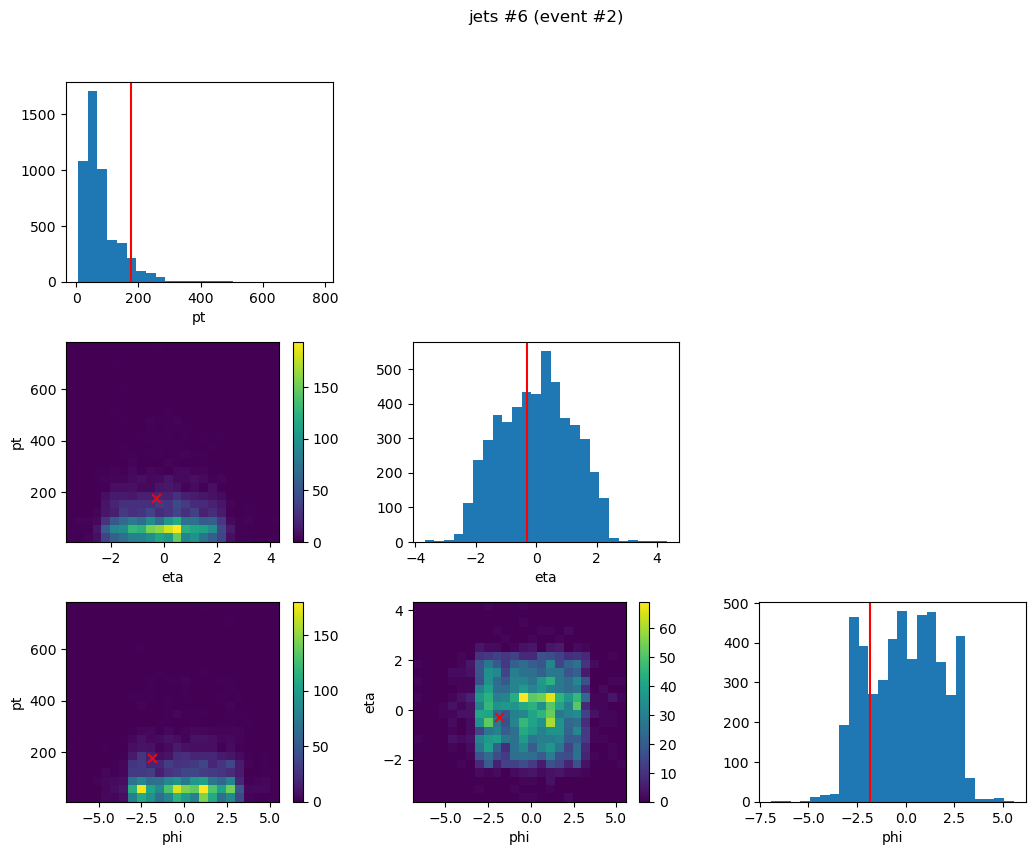

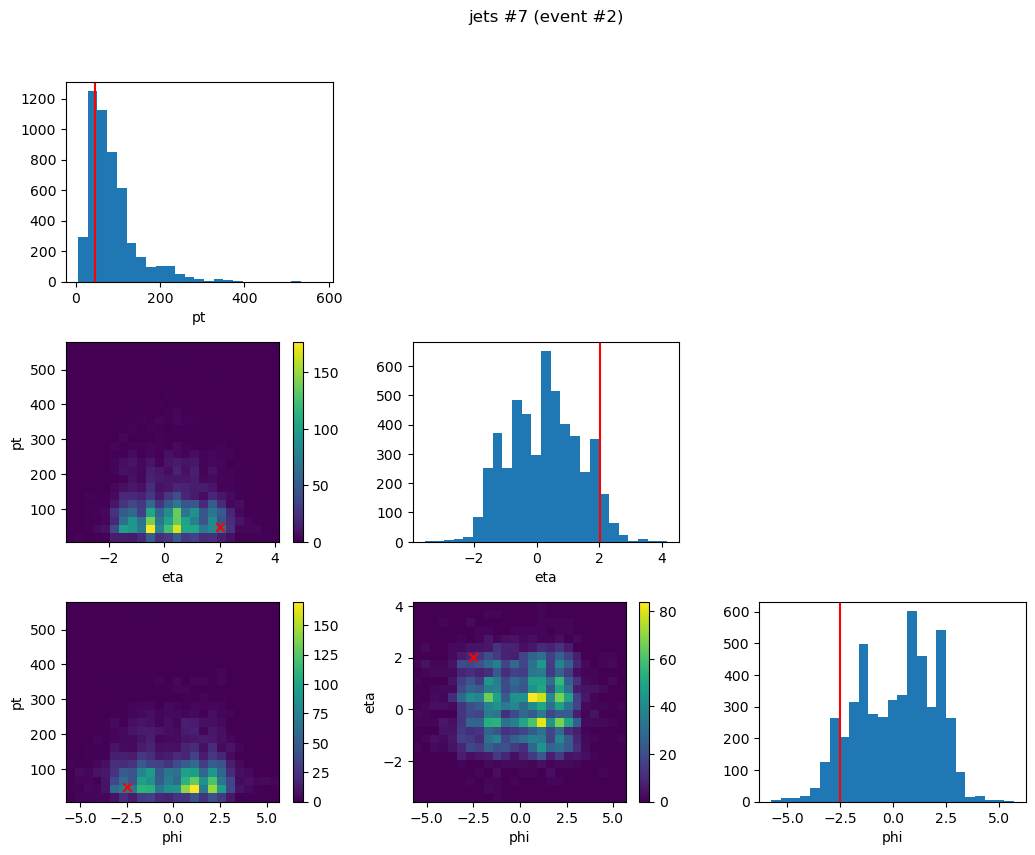

{'event_0_obj_electrons_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_electrons_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_0_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_2': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_3': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_4': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_5': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_6': <Figure size 1200x900 with 12 Axes>,
 'event_0_obj_jets_7': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_muons_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_met_0': <Figure size 800x600 with 5 Axes>,
 'event_1_obj_jets_0': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_1': <Figure size 1200x900 with 12 Axes>,
 'event_1_obj_jets_2': <Figure siz

In [21]:
sampling.make_sampling_plots(model,show=True)